In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
path="/its/home/drs25/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")
csfont = {'fontname':'Times New Roman'}
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

Using device: cuda


## Data set import

In [13]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def shuffle(self):
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        x,y=self.zoom_augment(self.AugmentedX.copy(),self.Augmentedy.copy(),[10,20,30,40])
        print(x.shape,self.AugmentedX.shape)
        self.AugmentedX=np.concatenate([self.AugmentedX,x])
        self.Augmentedy=np.concatenate([self.Augmentedy,y])

        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined
    def zoom_augment(self,dataX, dataY, zoom_factors):
        """
        Augment a dataset by zooming into the central region and resizing back to original dimensions.
        
        Parameters:
            dataX (numpy array): Dataset of shape (n, t, h, w).
            dataY (numpy array): Corresponding labels of shape (n, ...).
            zoom_factors (list): List of zoom-in percentages (e.g., [10, 20, 30]).
        
        Returns:
            augmented_dataX (list): List of augmented datasets, one for each zoom factor.
            augmented_dataY (list): List of label arrays corresponding to each augmented dataset.
        """
        n, t, h, w = dataX.shape
        augmented_dataX = []
        augmented_dataY = []
        
        for zoom in zoom_factors:
            crop_margin = int((zoom / 100) * min(h, w) / 2)
            cropped_and_resized = np.zeros_like(dataX)
            
            for i in range(n):
                for j in range(t):
                    # Crop the central region
                    cropped = dataX[i, j, crop_margin:h-crop_margin, crop_margin:w-crop_margin]
                    # Resize back to original dimensions
                    cropped_and_resized[i, j] = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
            
            augmented_dataX.append(cropped_and_resized)
            augmented_dataY.append(dataY.copy())  # Labels remain the same
        augmented_dataX=np.array(augmented_dataX)
        augmented_dataY=np.array(augmented_dataY)
        return augmented_dataX.reshape((len(zoom_factors)*augmented_dataX.shape[1],*augmented_dataX.shape[2:])), augmented_dataY.reshape((len(zoom_factors)*augmented_dataY.shape[1],))
    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
data=loaded(t=4)
data.applySobel()
data.augment()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


UnboundLocalError: local variable 'augmented_datay' referenced before assignment

### gen data

In [60]:
def genData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz") #X_data_15.npz
    data.applySobel()
    """data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data.X=np.concatenate([data.X,data2.X])
    data.y=np.concatenate([data.y,data2.y])
    del data2
    data3=loaded(to,filename="X_data_newMorph.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data3.X])
    data.y=np.concatenate([data.y,data3.y])
    del data3"""
    data.resize(percentage)
    #data.augment()
    data.shuffle()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_data_newMorph.npz")
    #d.applySobel()
    #p20=d.X[np.where(d.y==3)]
    #data.X=np.concatenate([data.X,p20])
    #data.y=np.concatenate([data.y,np.zeros((len(p20)))+11])
    #data.resize(percentage)
    print("LOADED DATASET...")
    #data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to)*data.X.shape[2],data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader

def genDataANN(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    data.shuffle()
    data.resize(percentage)
    print("LOADED DATASET...")
    data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to)*data.X.shape[2]*data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader
def gen3DData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    data.resize(percentage)
    n=int(len(data.X)*0.6)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_15.npz")
    #data.applySobel()
    #data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    #data3=loaded(to,filename="X_data_gel_15.npz")
    #data3.applySobel()
    #data.X=np.concatenate([data.X,data2.X,data3.X])
    #data.y=np.concatenate([data.y,data2.y,data3.y])
    #del data2
    #del data3
    data.augment()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
    #d.applySobel()
    #data.augment()
    data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to),data.X.shape[2]*data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader
def genCNNLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data3=loaded(to,filename="X_data_gel_15.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data2.X,data3.X])
    data.y=np.concatenate([data.y,data2.y,data3.y])
    del data2
    del data3
    data.augment()

    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

## Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self,input_height, input_width,output=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten_size = 10 * (input_height // 4) * (input_width // 4)
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class SimpleANN(nn.Module):
    def __init__(self,input, hidden,output=15):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
class Simple3DCNN(nn.Module):
    def __init__(self, input_depth, input_height, input_width):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        depth = input_depth
        height = input_height
        width = input_width
        
        depth = depth // 2  # after first pooling
        height = height // 2
        width = width // 2
        
        depth = depth // 2  # after second pooling
        height = height // 2
        width = width // 2
        
        # Number of output features from conv layers (channels * depth * height * width)
        self.flatten_size = 10 * depth * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class CNN_LSTM(nn.Module):
    def __init__(self, input_width, input_height, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        )
        
        # Calculate the CNN output size
        cnn_output_size = self._get_cnn_output_size(input_width, input_height)
        
        # Define the LSTM part
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define the final fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def _get_cnn_output_size(self, width, height):
        # Create a dummy tensor with the given width and height
        dummy_input = torch.zeros(1, 1, height, width)
        
        # Pass the dummy tensor through the CNN
        dummy_output = self.cnn(dummy_input)
        
        # Calculate the output size by flattening the output
        return dummy_output.view(-1).size(0)
    
    def forward(self, x):
        batch_size, c, sequence_length, h, w = x.size()
        # Reshape input to (batch_size * sequence_length, c, h, w) for CNN
        c_in = x.view(batch_size * sequence_length, c, h, w)
        
        # Pass through CNN
        c_out = self.cnn(c_in)
        
        # Flatten the CNN output
        c_out = c_out.view(c_out.size(0), -1)
        
        # Reshape to (batch_size, sequence_length, cnn_output_size) for LSTM
        lstm_in = c_out.view(batch_size, sequence_length, -1)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(lstm_in)
        
        # Get the output from the last time step
        output = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        output = self.fc(output)
        
        return output
    


## Train

In [9]:
def run(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleCNN(image.shape[0],image.shape[1],output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def runANN(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0]
    output=len(next(iter(train_loader))[1][0])
    print("SHAPE....",image.shape)
    model = SimpleANN(image.shape[0],400,output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def run3D(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    model = Simple3DCNN(image.shape[0],image.shape[1],image.shape[2]).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def calc(model,data_loader):
        correct=0
        summed=0.1
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            a=torch.argmax(outputs,axis=1)==torch.argmax(labels,axis=1)

            summed+=len(inputs)
            correct+=len(a[a==1])
        print("Accuracy:",(correct/summed)*100,"%")
        return correct/summed
def runLSTM(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleLSTM(image.shape[0],350,output,3).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def runLSTMcnn(train_loader,frm,to,num_epochs=150):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = CNN_LSTM(image.shape[1],image.shape[0],1000,1,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

### ANN train

In [15]:
torch.cuda.empty_cache()
train_loader,test_loader=genDataANN(0,4)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.48 GB
torch.Size([6300, 52800])
torch.Size([6300, 15])


/tmp/ipykernel_1576422/702361806.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


In [16]:
model,history=runANN(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelANN") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelANN")

SHAPE.... torch.Size([52800])
Epoch [1/100], Step [126/126], Loss: 324.9312
Epoch [11/100], Step [126/126], Loss: 48.6270
Epoch [21/100], Step [126/126], Loss: 10.9573
Epoch [31/100], Step [126/126], Loss: 4.1670
Epoch [41/100], Step [126/126], Loss: 2.2464
Epoch [51/100], Step [126/126], Loss: 1.4630
Epoch [61/100], Step [126/126], Loss: 1.0482
Epoch [71/100], Step [126/126], Loss: 0.8039
Epoch [81/100], Step [126/126], Loss: 0.6449
Epoch [91/100], Step [126/126], Loss: 0.5333
Finished Training
Accuracy: 99.9920641218951 %
0.999920641218951
Accuracy: 99.99801591238268 %
0.9999801591238269


### CNN train

In [33]:
torch.cuda.empty_cache()
train_loader,test_loader=genData(0,4)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelCNN") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/1477274522.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7170
Epoch [11/100], Step [42/42], Loss: 87.2587
Epoch [21/100], Step [42/42], Loss: 36.3228
Epoch [31/100], Step [42/42], Loss: 13.6951
Epoch [41/100], Step [42/42], Loss: 6.2801
Epoch [51/100], Step [42/42], Loss: 3.4708
Epoch [61/100], Step [42/42], Loss: 1.3726
Epoch [71/100], Step [42/42], Loss: 0.3402
Epoch [81/100], Step [42/42], Loss: 0.2194
Epoch [91/100], Step [42/42], Loss: 0.1500
Finished Training
Accuracy: 99.97619614377528 %
0.9997619614377529
Accuracy: 99.99404797333492 %
0.9999404797333492


In [61]:
accuracy_test=[]
accuracy_train=[]

for i in range(20):
    torch.cuda.empty_cache()
    train_loader,test_loader=genData(0,4)
    model,history=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
    torch.save(model.state_dict(), path+"/model/mymodel_CNN")
    accuracy_test.append(calc(model,test_loader))
    accuracy_train.append(calc(model,train_loader))

np.save(path+"/data/train_CNN_NM_accuracies_20_trials",np.array(accuracy_train))
np.save(path+"/data/test_CNN_NM_accuracies_20_trials",np.array(accuracy_test))

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6801
Epoch [11/100], Step [42/42], Loss: 87.6700
Epoch [21/100], Step [42/42], Loss: 43.3866
Epoch [31/100], Step [42/42], Loss: 30.7045
Epoch [41/100], Step [42/42], Loss: 24.7098
Epoch [51/100], Step [42/42], Loss: 20.7920
Epoch [61/100], Step [42/42], Loss: 17.3038
Epoch [71/100], Step [42/42], Loss: 15.1976
Epoch [81/100], Step [42/42], Loss: 12.5619
Epoch [91/100], Step [42/42], Loss: 10.8082
Finished Training
Accuracy: 89.97857652939776 %
0.8997857652939776
Accuracy: 91.5421701089221 %
0.9154217010892209
Accuracy: 89.97857652939776 %
Accuracy: 91.5421701089221 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7761
Epoch [11/100], Step [42/42], Loss: 90.7250
Epoch [21/100], Step [42/42], Loss: 43.6951
Epoch [31/100], Step [42/42], Loss: 31.1280
Epoch [41/100], Step [42/42], Loss: 24.3881
Epoch [51/100], Step [42/42], Loss: 19.6732
Epoch [61/100], Step [42/42], Loss: 17.2148
Epoch [71/100], Step [42/42], Loss: 15.7250
Epoch [81/100], Step [42/42], Loss: 13.5284
Epoch [91/100], Step [42/42], Loss: 11.1984
Finished Training
Accuracy: 85.93192097119733 %
0.8593192097119733
Accuracy: 89.57800130944588 %
0.8957800130944588
Accuracy: 85.93192097119733 %
Accuracy: 89.57800130944588 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7441
Epoch [11/100], Step [42/42], Loss: 80.5614
Epoch [21/100], Step [42/42], Loss: 40.4538
Epoch [31/100], Step [42/42], Loss: 28.8047
Epoch [41/100], Step [42/42], Loss: 23.2097
Epoch [51/100], Step [42/42], Loss: 19.4257
Epoch [61/100], Step [42/42], Loss: 16.9477
Epoch [71/100], Step [42/42], Loss: 13.8333
Epoch [81/100], Step [42/42], Loss: 11.6147
Epoch [91/100], Step [42/42], Loss: 9.1805
Finished Training
Accuracy: 87.12211378243275 %
0.8712211378243275
Accuracy: 89.2208797095411 %
0.892208797095411
Accuracy: 87.12211378243275 %
Accuracy: 89.2208797095411 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6841
Epoch [11/100], Step [42/42], Loss: 88.7053
Epoch [21/100], Step [42/42], Loss: 39.8999
Epoch [31/100], Step [42/42], Loss: 27.5174
Epoch [41/100], Step [42/42], Loss: 21.7776
Epoch [51/100], Step [42/42], Loss: 18.0802
Epoch [61/100], Step [42/42], Loss: 16.2184
Epoch [71/100], Step [42/42], Loss: 13.1398
Epoch [81/100], Step [42/42], Loss: 11.7324
Epoch [91/100], Step [42/42], Loss: 10.5707
Finished Training
Accuracy: 89.50249940490359 %
0.8950249940490359
Accuracy: 92.07785250877924 %
0.9207785250877925
Accuracy: 89.50249940490359 %
Accuracy: 92.07785250877924 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7297
Epoch [11/100], Step [42/42], Loss: 106.4800
Epoch [21/100], Step [42/42], Loss: 44.2181
Epoch [31/100], Step [42/42], Loss: 30.4420
Epoch [41/100], Step [42/42], Loss: 24.3740
Epoch [51/100], Step [42/42], Loss: 19.4533
Epoch [61/100], Step [42/42], Loss: 16.7447
Epoch [71/100], Step [42/42], Loss: 14.3602
Epoch [81/100], Step [42/42], Loss: 11.2031
Epoch [91/100], Step [42/42], Loss: 10.0708
Finished Training
Accuracy: 93.07307783860985 %
0.9307307783860985
Accuracy: 94.28010237485864 %
0.9428010237485864
Accuracy: 93.07307783860985 %
Accuracy: 94.28010237485864 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7786
Epoch [11/100], Step [42/42], Loss: 105.5470
Epoch [21/100], Step [42/42], Loss: 45.9972
Epoch [31/100], Step [42/42], Loss: 33.5193
Epoch [41/100], Step [42/42], Loss: 26.5868
Epoch [51/100], Step [42/42], Loss: 21.4878
Epoch [61/100], Step [42/42], Loss: 19.6475
Epoch [71/100], Step [42/42], Loss: 16.9169
Epoch [81/100], Step [42/42], Loss: 14.2105
Epoch [91/100], Step [42/42], Loss: 12.2404
Finished Training
Accuracy: 87.836229469174 %
0.87836229469174
Accuracy: 88.03047437652522 %
0.8803047437652521
Accuracy: 87.836229469174 %
Accuracy: 88.03047437652522 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6737
Epoch [11/100], Step [42/42], Loss: 86.0379
Epoch [21/100], Step [42/42], Loss: 41.9282
Epoch [31/100], Step [42/42], Loss: 30.4464
Epoch [41/100], Step [42/42], Loss: 23.2918
Epoch [51/100], Step [42/42], Loss: 19.9026
Epoch [61/100], Step [42/42], Loss: 17.7808
Epoch [71/100], Step [42/42], Loss: 14.7576
Epoch [81/100], Step [42/42], Loss: 13.2286
Epoch [91/100], Step [42/42], Loss: 11.7440
Finished Training
Accuracy: 94.26327064984527 %
0.9426327064984527
Accuracy: 94.9348253080174 %
0.9493482530801739
Accuracy: 94.26327064984527 %
Accuracy: 94.9348253080174 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7946
Epoch [11/100], Step [42/42], Loss: 110.8857
Epoch [21/100], Step [42/42], Loss: 58.3534
Epoch [31/100], Step [42/42], Loss: 36.1053
Epoch [41/100], Step [42/42], Loss: 27.3747
Epoch [51/100], Step [42/42], Loss: 21.7281
Epoch [61/100], Step [42/42], Loss: 19.3915
Epoch [71/100], Step [42/42], Loss: 15.7538
Epoch [81/100], Step [42/42], Loss: 13.3200
Epoch [91/100], Step [42/42], Loss: 11.4209
Finished Training
Accuracy: 90.93073077838609 %
0.9093073077838609
Accuracy: 91.78025117552528 %
0.9178025117552527
Accuracy: 90.93073077838609 %
Accuracy: 91.78025117552528 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6996
Epoch [11/100], Step [42/42], Loss: 94.5498
Epoch [21/100], Step [42/42], Loss: 46.9505
Epoch [31/100], Step [42/42], Loss: 35.1348
Epoch [41/100], Step [42/42], Loss: 28.2195
Epoch [51/100], Step [42/42], Loss: 23.7800
Epoch [61/100], Step [42/42], Loss: 20.8100
Epoch [71/100], Step [42/42], Loss: 18.2803
Epoch [81/100], Step [42/42], Loss: 15.5946
Epoch [91/100], Step [42/42], Loss: 14.0717
Finished Training
Accuracy: 84.26565103546774 %
0.8426565103546774
Accuracy: 84.45925837747752 %
0.8445925837747753
Accuracy: 84.26565103546774 %
Accuracy: 84.45925837747752 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6683
Epoch [11/100], Step [42/42], Loss: 76.6625
Epoch [21/100], Step [42/42], Loss: 40.4365
Epoch [31/100], Step [42/42], Loss: 29.9023
Epoch [41/100], Step [42/42], Loss: 24.3515
Epoch [51/100], Step [42/42], Loss: 20.4096
Epoch [61/100], Step [42/42], Loss: 16.2751
Epoch [71/100], Step [42/42], Loss: 14.0691
Epoch [81/100], Step [42/42], Loss: 12.5408
Epoch [91/100], Step [42/42], Loss: 10.7189
Finished Training
Accuracy: 87.59819090692692 %
0.8759819090692692
Accuracy: 89.04231890958873 %
0.8904231890958872
Accuracy: 87.59819090692692 %
Accuracy: 89.04231890958873 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7580
Epoch [11/100], Step [42/42], Loss: 108.4046
Epoch [21/100], Step [42/42], Loss: 47.3487
Epoch [31/100], Step [42/42], Loss: 31.8683
Epoch [41/100], Step [42/42], Loss: 24.5001
Epoch [51/100], Step [42/42], Loss: 20.4283
Epoch [61/100], Step [42/42], Loss: 17.1787
Epoch [71/100], Step [42/42], Loss: 15.0821
Epoch [81/100], Step [42/42], Loss: 12.2294
Epoch [91/100], Step [42/42], Loss: 10.5636
Finished Training
Accuracy: 85.93192097119733 %
0.8593192097119733
Accuracy: 87.01862984346171 %
0.870186298434617
Accuracy: 85.93192097119733 %
Accuracy: 87.01862984346171 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7158
Epoch [11/100], Step [42/42], Loss: 91.7618
Epoch [21/100], Step [42/42], Loss: 45.5880
Epoch [31/100], Step [42/42], Loss: 33.3855
Epoch [41/100], Step [42/42], Loss: 26.1650
Epoch [51/100], Step [42/42], Loss: 22.2770
Epoch [61/100], Step [42/42], Loss: 19.2595
Epoch [71/100], Step [42/42], Loss: 16.7152
Epoch [81/100], Step [42/42], Loss: 14.3198
Epoch [91/100], Step [42/42], Loss: 13.0989
Finished Training
Accuracy: 88.07426803142108 %
0.8807426803142109
Accuracy: 87.67335277662043 %
0.8767335277662044
Accuracy: 88.07426803142108 %
Accuracy: 87.67335277662043 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6806
Epoch [11/100], Step [42/42], Loss: 94.0307
Epoch [21/100], Step [42/42], Loss: 43.5792
Epoch [31/100], Step [42/42], Loss: 30.4854
Epoch [41/100], Step [42/42], Loss: 24.4721
Epoch [51/100], Step [42/42], Loss: 20.7858
Epoch [61/100], Step [42/42], Loss: 17.0438
Epoch [71/100], Step [42/42], Loss: 15.1159
Epoch [81/100], Step [42/42], Loss: 12.4243
Epoch [91/100], Step [42/42], Loss: 11.0442
Finished Training
Accuracy: 90.93073077838609 %
0.9093073077838609
Accuracy: 92.73257544193798 %
0.9273257544193798
Accuracy: 90.93073077838609 %
Accuracy: 92.73257544193798 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.4868
Epoch [11/100], Step [42/42], Loss: 58.4876
Epoch [21/100], Step [42/42], Loss: 36.9627
Epoch [31/100], Step [42/42], Loss: 27.4268
Epoch [41/100], Step [42/42], Loss: 22.4421
Epoch [51/100], Step [42/42], Loss: 18.4047
Epoch [61/100], Step [42/42], Loss: 15.5063
Epoch [71/100], Step [42/42], Loss: 13.7086
Epoch [81/100], Step [42/42], Loss: 12.0518
Epoch [91/100], Step [42/42], Loss: 10.1292
Finished Training
Accuracy: 89.97857652939776 %
0.8997857652939776
Accuracy: 93.03017677519195 %
0.9303017677519195
Accuracy: 89.97857652939776 %
Accuracy: 93.03017677519195 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6267
Epoch [11/100], Step [42/42], Loss: 71.2041
Epoch [21/100], Step [42/42], Loss: 38.9834
Epoch [31/100], Step [42/42], Loss: 29.2060
Epoch [41/100], Step [42/42], Loss: 23.3265
Epoch [51/100], Step [42/42], Loss: 20.4486
Epoch [61/100], Step [42/42], Loss: 16.9972
Epoch [71/100], Step [42/42], Loss: 14.6738
Epoch [81/100], Step [42/42], Loss: 12.9194
Epoch [91/100], Step [42/42], Loss: 12.2733
Finished Training
Accuracy: 90.69269221613901 %
0.9069269221613901
Accuracy: 91.24456877566813 %
0.9124456877566812
Accuracy: 90.69269221613901 %
Accuracy: 91.24456877566813 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6904
Epoch [11/100], Step [42/42], Loss: 107.2112
Epoch [21/100], Step [42/42], Loss: 54.5248
Epoch [31/100], Step [42/42], Loss: 35.6404
Epoch [41/100], Step [42/42], Loss: 27.6095
Epoch [51/100], Step [42/42], Loss: 22.8595
Epoch [61/100], Step [42/42], Loss: 18.4593
Epoch [71/100], Step [42/42], Loss: 15.7372
Epoch [81/100], Step [42/42], Loss: 13.8353
Epoch [91/100], Step [42/42], Loss: 11.7361
Finished Training
Accuracy: 89.97857652939776 %
0.8997857652939776
Accuracy: 88.20903517647758 %
0.8820903517647759
Accuracy: 89.97857652939776 %
Accuracy: 88.20903517647758 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7024
Epoch [11/100], Step [42/42], Loss: 109.2948
Epoch [21/100], Step [42/42], Loss: 47.2226
Epoch [31/100], Step [42/42], Loss: 30.2285
Epoch [41/100], Step [42/42], Loss: 23.1372
Epoch [51/100], Step [42/42], Loss: 18.6102
Epoch [61/100], Step [42/42], Loss: 16.3001
Epoch [71/100], Step [42/42], Loss: 14.1779
Epoch [81/100], Step [42/42], Loss: 11.5301
Epoch [91/100], Step [42/42], Loss: 9.3793
Finished Training
Accuracy: 87.36015234467983 %
0.8736015234467983
Accuracy: 89.75656210939825 %
0.8975656210939825
Accuracy: 87.36015234467983 %
Accuracy: 89.75656210939825 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.7471
Epoch [11/100], Step [42/42], Loss: 102.2371
Epoch [21/100], Step [42/42], Loss: 46.3505
Epoch [31/100], Step [42/42], Loss: 32.8294
Epoch [41/100], Step [42/42], Loss: 26.0399
Epoch [51/100], Step [42/42], Loss: 21.6644
Epoch [61/100], Step [42/42], Loss: 17.9809
Epoch [71/100], Step [42/42], Loss: 16.0022
Epoch [81/100], Step [42/42], Loss: 13.5968
Epoch [91/100], Step [42/42], Loss: 11.0637
Finished Training
Accuracy: 86.16995953344441 %
0.8616995953344442
Accuracy: 86.66150824355694 %
0.8666150824355694
Accuracy: 86.16995953344441 %
Accuracy: 86.66150824355694 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6621
Epoch [11/100], Step [42/42], Loss: 86.5362
Epoch [21/100], Step [42/42], Loss: 40.5466
Epoch [31/100], Step [42/42], Loss: 27.6415
Epoch [41/100], Step [42/42], Loss: 21.5161
Epoch [51/100], Step [42/42], Loss: 17.6405
Epoch [61/100], Step [42/42], Loss: 14.2848
Epoch [71/100], Step [42/42], Loss: 12.4612
Epoch [81/100], Step [42/42], Loss: 11.0538
Epoch [91/100], Step [42/42], Loss: 8.9861
Finished Training
Accuracy: 91.64484646512734 %
0.9164484646512735
Accuracy: 92.31593357538243 %
0.9231593357538243
Accuracy: 91.64484646512734 %
Accuracy: 92.31593357538243 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/3301776505.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6670
Epoch [11/100], Step [42/42], Loss: 78.3404
Epoch [21/100], Step [42/42], Loss: 41.1482
Epoch [31/100], Step [42/42], Loss: 29.9278
Epoch [41/100], Step [42/42], Loss: 23.2873
Epoch [51/100], Step [42/42], Loss: 19.1132
Epoch [61/100], Step [42/42], Loss: 17.0560
Epoch [71/100], Step [42/42], Loss: 14.5727
Epoch [81/100], Step [42/42], Loss: 12.2366
Epoch [91/100], Step [42/42], Loss: 10.8997
Finished Training
Accuracy: 93.7871935253511 %
0.937871935253511
Accuracy: 92.79209570858879 %
0.9279209570858878
Accuracy: 93.7871935253511 %
Accuracy: 92.79209570858879 %


In [62]:
accuracy_test

[0.8997857652939776,
 0.8593192097119733,
 0.8712211378243275,
 0.8950249940490359,
 0.9307307783860985,
 0.87836229469174,
 0.9426327064984527,
 0.9093073077838609,
 0.8426565103546774,
 0.8759819090692692,
 0.8593192097119733,
 0.8807426803142109,
 0.9093073077838609,
 0.8997857652939776,
 0.9069269221613901,
 0.8997857652939776,
 0.8736015234467983,
 0.8616995953344442,
 0.9164484646512735,
 0.937871935253511]

In [32]:
#   mew morph
#model 1
#95 93
#model2
#88 88
#model 3 
#95.2 96.6
#model 4
#92.5 92.4
#model 5
#92 93
#model 6
#98.2 98.9
print(np.average([95,88,95.2,92.5,92,98]))
#   standard
#model 1
#99.9 99.9
#model2
#99.9 99.9
#model 3 
#99.9 99.9
#model 4
#99.9 99.9
#model 5
#99.9 99.9
print(np.average([99.9,99.9,99.9,99.9,99.9]))

93.45
99.9


In [ ]:
plt.plot(history)
plt.grid(True)
plt.title("Loss of CNN on both datasets",fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path+"/images/loss_of_uber_model.pdf")
plt.show()

: 

In [ ]:
train_loader,test_loader,unique=genData(0,4)
data=loaded(4,filename="X_data_newMorph.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=13).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()

: 

In [ ]:


ar=[]
acc=[]
for i in range(5):
    try:
        torch.cuda.empty_cache()
        train_loader,test_loader,unique=genData(0,4)
        model,history=run(train_loader,0,4)
        ar.append(history)
        print(calc(model,test_loader))
        print(calc(model,train_loader))
        acc.append(calc(model,test_loader))
        if acc[-1]>=max(acc):
            torch.save(model.state_dict(), path+"/model/mymmodel_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
    except MemoryError as e:
        try:
            del train_loader
            del test_loader
            del model
        except: 
            pass
ar=np.array(ar)
acc=np.array(acc)


np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/accuracies_of_NM_uber",acc)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/loss_of_NM_uber",ar)

: 

In [ ]:
#T EXPERIEMTN

ar_=[]
acc_=[]
for j in range(1,20,2):
    clear_output(wait=True)
    print("t SIZE:",j)
    ar=[]
    acc=[]
    for i in range(3):
        try:
            torch.cuda.empty_cache()
            train_loader,test_loader,unique=genLSTMData(0,j)
            model,history=runLSTM(train_loader,0,j)
            ar.append(history)
            print(calc(model,test_loader))
            print(calc(model,train_loader))
            acc.append(calc(model,test_loader))
            if acc[-1]>=max(acc):
                torch.save(model.state_dict(), path+"/models/lstm_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
            del train_loader
            del test_loader
            del model
        except MemoryError as e:
            try:
                del train_loader
                del test_loader
                del model
            except: 
                pass
    ar=np.array(ar)
    acc=np.array(acc)
    ar_.append(ar)
    acc_.append(acc)
    np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/LSTMaccuracies_of_NM",np.array(acc_))
    np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/LSTMloss_of_NM",np.array(ar_))

: 

In [ ]:
test_scores=np.zeros((10,14,3))
train_scores=np.zeros((10,14,3))
t_averages=np.zeros((10*14*3))

#test_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/test_scores.npy")
#train_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/train_scores.npy")
c=0
for i in range(1,10): #loop through frm dimention
    for j in range(i+1,15): #loop though to dimention
        print(">>>>",i,j,"\nMax:",np.max(test_scores)*100,"%","\nEstimated time left:",(np.average(t_averages[t_averages!=0])*len(t_averages[t_averages==0]))/60,"minutes")
        for trial in range(3):
            t=time.time()
            torch.cuda.empty_cache()
            train_loader,test_loader,__=genData(i,j)
            model=run(train_loader,i,j)
            test_scores[i][j-1][trial]=calc(model,test_loader)
            train_scores[i][j-1][trial]=calc(model,train_loader)
            torch.cuda.empty_cache()
            del train_loader
            del test_loader
            del model
            t2=time.time()
            t_averages[c]=t2-t
            c+=1
        clear_output(wait=True)
        np.save(path+"saves/test_scores_NM_",test_scores)
        np.save(path+"saves/train_scores_NM",train_scores)




: 

#### resolution

In [14]:

resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
scores_test=np.zeros((len(resolutions),3))#np.load(path+"/data/test_resolutions_new.npy")#np.load(path+"/data/test_resolutions_uber.npy")#np.zeros((len(resolutions),3))
scores_train=np.zeros((len(resolutions),3))#np.load(path+"/data/train_resolutions_new.npy")#np.load(path+"/data/train_resolutions_uber.npy")#np.zeros((len(resolutions),3))
#ind=resolutions.index(0.7)
ind=0
try:
    for i, res in enumerate((resolutions[ind:])): #
        i+=ind
        print("Testing resolution",res)
        for j in range(3): #three trials on each
            torch.cuda.empty_cache()
            train_loader,test_loader=genData(0,4,res)
            model,history=run(train_loader,0,4,num_epochs = 130)
            test_acc=calc(model,test_loader)
            train_acc=calc(model,train_loader)
            #look at other stuff
            del train_loader
            del test_loader
            torch.cuda.empty_cache()
            #scores_test_NM[i][j]=len(a[a==0])/len(preds)
            scores_test[i][j]=test_acc
            scores_train[i][j]=train_acc
            print("\t\t",test_acc*100,"%",train_acc*100,"%")
            del model
except Exception as e:
    print(e)
    print(res)
np.save(path+"/data/test_resolutions_new",scores_test)
np.save(path+"/data/train_resolutions_new",scores_train)


Testing resolution 0.05
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.0 GB
torch.Size([2100, 1, 20, 6])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7739


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7126
Epoch [21/130], Step [42/42], Loss: 113.6718
Epoch [31/130], Step [42/42], Loss: 113.6412
Epoch [41/130], Step [42/42], Loss: 113.6139
Epoch [51/130], Step [42/42], Loss: 113.5881
Epoch [61/130], Step [42/42], Loss: 113.5621
Epoch [71/130], Step [42/42], Loss: 113.5310
Epoch [81/130], Step [42/42], Loss: 113.4939
Epoch [91/130], Step [42/42], Loss: 113.4466
Epoch [101/130], Step [42/42], Loss: 113.3847
Epoch [111/130], Step [42/42], Loss: 113.2970
Epoch [121/130], Step [42/42], Loss: 113.1694
Finished Training
Accuracy: 5.474886931682932 %
Accuracy: 7.559073864650914 %
		 5.474886931682932 % 7.559073864650914 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.0 GB
torch.Size([2100, 1, 20, 6])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7811


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7084
Epoch [21/130], Step [42/42], Loss: 113.6558
Epoch [31/130], Step [42/42], Loss: 113.6097
Epoch [41/130], Step [42/42], Loss: 113.5609
Epoch [51/130], Step [42/42], Loss: 113.5052
Epoch [61/130], Step [42/42], Loss: 113.4336
Epoch [71/130], Step [42/42], Loss: 113.3347
Epoch [81/130], Step [42/42], Loss: 113.1901
Epoch [91/130], Step [42/42], Loss: 112.9498
Epoch [101/130], Step [42/42], Loss: 112.5597
Epoch [111/130], Step [42/42], Loss: 111.8396
Epoch [121/130], Step [42/42], Loss: 110.3420
Finished Training
Accuracy: 13.568198048083788 %
Accuracy: 13.630141063031964 %
		 13.568198048083788 % 13.630141063031964 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.0 GB
torch.Size([2100, 1, 20, 6])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7812


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7237
Epoch [21/130], Step [42/42], Loss: 113.6850
Epoch [31/130], Step [42/42], Loss: 113.6543
Epoch [41/130], Step [42/42], Loss: 113.6242
Epoch [51/130], Step [42/42], Loss: 113.5860
Epoch [61/130], Step [42/42], Loss: 113.5475
Epoch [71/130], Step [42/42], Loss: 113.5003
Epoch [81/130], Step [42/42], Loss: 113.4377
Epoch [91/130], Step [42/42], Loss: 113.3476
Epoch [101/130], Step [42/42], Loss: 113.2306
Epoch [111/130], Step [42/42], Loss: 113.0524
Epoch [121/130], Step [42/42], Loss: 112.7666
Finished Training
Accuracy: 11.663889550107116 %
Accuracy: 14.403904529492292 %
		 11.663889550107116 % 14.403904529492292 %
Testing resolution 0.1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.01 GB
torch.Size([2100, 1, 44, 12])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8139


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7506
Epoch [21/130], Step [42/42], Loss: 113.7121
Epoch [31/130], Step [42/42], Loss: 113.6808
Epoch [41/130], Step [42/42], Loss: 113.6517
Epoch [51/130], Step [42/42], Loss: 113.6222
Epoch [61/130], Step [42/42], Loss: 113.5901
Epoch [71/130], Step [42/42], Loss: 113.5514
Epoch [81/130], Step [42/42], Loss: 113.4993
Epoch [91/130], Step [42/42], Loss: 113.4248
Epoch [101/130], Step [42/42], Loss: 113.3069
Epoch [111/130], Step [42/42], Loss: 113.1143
Epoch [121/130], Step [42/42], Loss: 112.7668
Finished Training
Accuracy: 18.805046417519637 %
Accuracy: 21.129694661032083 %
		 18.805046417519637 % 21.129694661032083 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.01 GB
torch.Size([2100, 1, 44, 12])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8131


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6950
Epoch [21/130], Step [42/42], Loss: 113.6112
Epoch [31/130], Step [42/42], Loss: 113.5426
Epoch [41/130], Step [42/42], Loss: 113.4788
Epoch [51/130], Step [42/42], Loss: 113.4053
Epoch [61/130], Step [42/42], Loss: 113.3051
Epoch [71/130], Step [42/42], Loss: 113.1501
Epoch [81/130], Step [42/42], Loss: 112.8970
Epoch [91/130], Step [42/42], Loss: 112.4019
Epoch [101/130], Step [42/42], Loss: 111.2135
Epoch [111/130], Step [42/42], Loss: 107.5177
Epoch [121/130], Step [42/42], Loss: 98.5753
Finished Training
Accuracy: 22.137586288978813 %
Accuracy: 27.31980239271472 %
		 22.137586288978813 % 27.31980239271472 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.01 GB
torch.Size([2100, 1, 44, 12])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8245


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7435
Epoch [21/130], Step [42/42], Loss: 113.6869
Epoch [31/130], Step [42/42], Loss: 113.6373
Epoch [41/130], Step [42/42], Loss: 113.5932
Epoch [51/130], Step [42/42], Loss: 113.5434
Epoch [61/130], Step [42/42], Loss: 113.4795
Epoch [71/130], Step [42/42], Loss: 113.3925
Epoch [81/130], Step [42/42], Loss: 113.2662
Epoch [91/130], Step [42/42], Loss: 113.0647
Epoch [101/130], Step [42/42], Loss: 112.7090
Epoch [111/130], Step [42/42], Loss: 111.9820
Epoch [121/130], Step [42/42], Loss: 110.1567
Finished Training
Accuracy: 16.18662223280171 %
Accuracy: 20.59401226117493 %
		 16.18662223280171 % 20.59401226117493 %
Testing resolution 0.15
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.02 GB
torch.Size([2100, 1, 64, 18])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8190


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6318
Epoch [21/130], Step [42/42], Loss: 113.4698
Epoch [31/130], Step [42/42], Loss: 113.2335
Epoch [41/130], Step [42/42], Loss: 112.8076
Epoch [51/130], Step [42/42], Loss: 111.6749
Epoch [61/130], Step [42/42], Loss: 106.1564
Epoch [71/130], Step [42/42], Loss: 88.6388
Epoch [81/130], Step [42/42], Loss: 68.5816
Epoch [91/130], Step [42/42], Loss: 51.6234
Epoch [101/130], Step [42/42], Loss: 42.9745
Epoch [111/130], Step [42/42], Loss: 37.8363
Epoch [121/130], Step [42/42], Loss: 35.5148
Finished Training
Accuracy: 62.36610330873601 %
Accuracy: 66.1270162490328 %
		 62.36610330873601 % 66.1270162490328 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.02 GB
torch.Size([2100, 1, 64, 18])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7910


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7214
Epoch [21/130], Step [42/42], Loss: 113.6638
Epoch [31/130], Step [42/42], Loss: 113.6094
Epoch [41/130], Step [42/42], Loss: 113.5350
Epoch [51/130], Step [42/42], Loss: 113.4114
Epoch [61/130], Step [42/42], Loss: 113.1830
Epoch [71/130], Step [42/42], Loss: 112.6890
Epoch [81/130], Step [42/42], Loss: 111.1838
Epoch [91/130], Step [42/42], Loss: 104.2282
Epoch [101/130], Step [42/42], Loss: 94.5898
Epoch [111/130], Step [42/42], Loss: 78.8890
Epoch [121/130], Step [42/42], Loss: 55.2305
Finished Training
Accuracy: 50.7022137586289 %
Accuracy: 54.699125052080234 %
		 50.7022137586289 % 54.699125052080234 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.02 GB
torch.Size([2100, 1, 64, 18])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8477


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7282
Epoch [21/130], Step [42/42], Loss: 113.6501
Epoch [31/130], Step [42/42], Loss: 113.5816
Epoch [41/130], Step [42/42], Loss: 113.5083
Epoch [51/130], Step [42/42], Loss: 113.4128
Epoch [61/130], Step [42/42], Loss: 113.2634
Epoch [71/130], Step [42/42], Loss: 113.0045
Epoch [81/130], Step [42/42], Loss: 112.4498
Epoch [91/130], Step [42/42], Loss: 110.8999
Epoch [101/130], Step [42/42], Loss: 103.5855
Epoch [111/130], Step [42/42], Loss: 88.4299
Epoch [121/130], Step [42/42], Loss: 62.8972
Finished Training
Accuracy: 50.7022137586289 %
Accuracy: 48.86613892030237 %
		 50.7022137586289 % 48.86613892030237 %
Testing resolution 0.2
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.03 GB
torch.Size([2100, 1, 88, 24])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7910


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6467
Epoch [21/130], Step [42/42], Loss: 113.4953
Epoch [31/130], Step [42/42], Loss: 113.2455
Epoch [41/130], Step [42/42], Loss: 112.7163
Epoch [51/130], Step [42/42], Loss: 111.1056
Epoch [61/130], Step [42/42], Loss: 102.1271
Epoch [71/130], Step [42/42], Loss: 93.6108
Epoch [81/130], Step [42/42], Loss: 73.3849
Epoch [91/130], Step [42/42], Loss: 50.8001
Epoch [101/130], Step [42/42], Loss: 39.8174
Epoch [111/130], Step [42/42], Loss: 34.4178
Epoch [121/130], Step [42/42], Loss: 31.3915
Finished Training
Accuracy: 66.65079742918353 %
Accuracy: 68.74590798166777 %
		 66.65079742918353 % 68.74590798166777 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.03 GB
torch.Size([2100, 1, 88, 24])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.6984


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.5927
Epoch [21/130], Step [42/42], Loss: 113.5086
Epoch [31/130], Step [42/42], Loss: 113.3860
Epoch [41/130], Step [42/42], Loss: 113.1519
Epoch [51/130], Step [42/42], Loss: 112.7150
Epoch [61/130], Step [42/42], Loss: 111.5622
Epoch [71/130], Step [42/42], Loss: 106.6109
Epoch [81/130], Step [42/42], Loss: 96.7818
Epoch [91/130], Step [42/42], Loss: 87.8149
Epoch [101/130], Step [42/42], Loss: 61.0205
Epoch [111/130], Step [42/42], Loss: 44.2241
Epoch [121/130], Step [42/42], Loss: 36.0698
Finished Training
Accuracy: 75.22018567007855 %
Accuracy: 69.10302958157253 %
		 75.22018567007855 % 69.10302958157253 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.03 GB
torch.Size([2100, 1, 88, 24])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7929


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6783
Epoch [21/130], Step [42/42], Loss: 113.5713
Epoch [31/130], Step [42/42], Loss: 113.4415
Epoch [41/130], Step [42/42], Loss: 113.2171
Epoch [51/130], Step [42/42], Loss: 112.6802
Epoch [61/130], Step [42/42], Loss: 110.8185
Epoch [71/130], Step [42/42], Loss: 99.9658
Epoch [81/130], Step [42/42], Loss: 90.5523
Epoch [91/130], Step [42/42], Loss: 67.9928
Epoch [101/130], Step [42/42], Loss: 48.5688
Epoch [111/130], Step [42/42], Loss: 39.1930
Epoch [121/130], Step [42/42], Loss: 34.5441
Finished Training
Accuracy: 69.50726017614853 %
Accuracy: 68.68638771501698 %
		 69.50726017614853 % 68.68638771501698 %
Testing resolution 0.25
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.05 GB
torch.Size([2100, 1, 108, 30])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7297


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.5884
Epoch [21/130], Step [42/42], Loss: 113.4107
Epoch [31/130], Step [42/42], Loss: 112.9938
Epoch [41/130], Step [42/42], Loss: 111.3135
Epoch [51/130], Step [42/42], Loss: 97.4735
Epoch [61/130], Step [42/42], Loss: 70.4523
Epoch [71/130], Step [42/42], Loss: 46.4063
Epoch [81/130], Step [42/42], Loss: 37.0002
Epoch [91/130], Step [42/42], Loss: 32.0977
Epoch [101/130], Step [42/42], Loss: 28.9819
Epoch [111/130], Step [42/42], Loss: 27.5950
Epoch [121/130], Step [42/42], Loss: 25.8936
Finished Training
Accuracy: 72.36372292311354 %
Accuracy: 73.92417118028689 %
		 72.36372292311354 % 73.92417118028689 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.05 GB
torch.Size([2100, 1, 108, 30])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8546


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7204
Epoch [21/130], Step [42/42], Loss: 113.5794
Epoch [31/130], Step [42/42], Loss: 113.3333
Epoch [41/130], Step [42/42], Loss: 112.6630
Epoch [51/130], Step [42/42], Loss: 108.7908
Epoch [61/130], Step [42/42], Loss: 91.1281
Epoch [71/130], Step [42/42], Loss: 58.9679
Epoch [81/130], Step [42/42], Loss: 42.4466
Epoch [91/130], Step [42/42], Loss: 35.0838
Epoch [101/130], Step [42/42], Loss: 31.3898
Epoch [111/130], Step [42/42], Loss: 28.7872
Epoch [121/130], Step [42/42], Loss: 26.7403
Finished Training
Accuracy: 74.74410854558438 %
Accuracy: 72.07904291411225 %
		 74.74410854558438 % 72.07904291411225 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.05 GB
torch.Size([2100, 1, 108, 30])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7962


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6895
Epoch [21/130], Step [42/42], Loss: 113.5981
Epoch [31/130], Step [42/42], Loss: 113.4841
Epoch [41/130], Step [42/42], Loss: 113.2842
Epoch [51/130], Step [42/42], Loss: 112.8280
Epoch [61/130], Step [42/42], Loss: 111.2883
Epoch [71/130], Step [42/42], Loss: 101.2015
Epoch [81/130], Step [42/42], Loss: 91.4299
Epoch [91/130], Step [42/42], Loss: 64.9688
Epoch [101/130], Step [42/42], Loss: 45.0619
Epoch [111/130], Step [42/42], Loss: 36.6865
Epoch [121/130], Step [42/42], Loss: 31.7273
Finished Training
Accuracy: 68.79314448940728 %
Accuracy: 64.99613118266771 %
		 68.79314448940728 % 64.99613118266771 %
Testing resolution 0.3
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.07 GB
torch.Size([2100, 1, 132, 36])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8712


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.7360
Epoch [21/130], Step [42/42], Loss: 113.5351
Epoch [31/130], Step [42/42], Loss: 113.0624
Epoch [41/130], Step [42/42], Loss: 110.9208
Epoch [51/130], Step [42/42], Loss: 96.8902
Epoch [61/130], Step [42/42], Loss: 75.1695
Epoch [71/130], Step [42/42], Loss: 47.2840
Epoch [81/130], Step [42/42], Loss: 36.5893
Epoch [91/130], Step [42/42], Loss: 32.2216
Epoch [101/130], Step [42/42], Loss: 29.4843
Epoch [111/130], Step [42/42], Loss: 28.0431
Epoch [121/130], Step [42/42], Loss: 25.4796
Finished Training
Accuracy: 74.74410854558438 %
Accuracy: 75.94786024641391 %
		 74.74410854558438 % 75.94786024641391 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.07 GB
torch.Size([2100, 1, 132, 36])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8046


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6806
Epoch [21/130], Step [42/42], Loss: 113.5384
Epoch [31/130], Step [42/42], Loss: 113.2357
Epoch [41/130], Step [42/42], Loss: 112.1744
Epoch [51/130], Step [42/42], Loss: 102.3678
Epoch [61/130], Step [42/42], Loss: 80.5813
Epoch [71/130], Step [42/42], Loss: 50.6829
Epoch [81/130], Step [42/42], Loss: 39.8776
Epoch [91/130], Step [42/42], Loss: 34.6882
Epoch [101/130], Step [42/42], Loss: 31.7210
Epoch [111/130], Step [42/42], Loss: 29.3609
Epoch [121/130], Step [42/42], Loss: 28.4298
Finished Training
Accuracy: 71.64960723637229 %
Accuracy: 69.81727278138207 %
		 71.64960723637229 % 69.81727278138207 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.07 GB
torch.Size([2100, 1, 132, 36])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8187


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6631
Epoch [21/130], Step [42/42], Loss: 113.4829
Epoch [31/130], Step [42/42], Loss: 113.1346
Epoch [41/130], Step [42/42], Loss: 111.8874
Epoch [51/130], Step [42/42], Loss: 98.6954
Epoch [61/130], Step [42/42], Loss: 68.3651
Epoch [71/130], Step [42/42], Loss: 45.8990
Epoch [81/130], Step [42/42], Loss: 37.5444
Epoch [91/130], Step [42/42], Loss: 32.9342
Epoch [101/130], Step [42/42], Loss: 30.0794
Epoch [111/130], Step [42/42], Loss: 28.1999
Epoch [121/130], Step [42/42], Loss: 25.8643
Finished Training
Accuracy: 69.26922161390145 %
Accuracy: 69.99583358133444 %
		 69.26922161390145 % 69.99583358133444 %
Testing resolution 0.35
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.1 GB
torch.Size([2100, 1, 152, 42])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8315


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6455
Epoch [21/130], Step [42/42], Loss: 113.3915
Epoch [31/130], Step [42/42], Loss: 112.6310
Epoch [41/130], Step [42/42], Loss: 104.4815
Epoch [51/130], Step [42/42], Loss: 73.3224
Epoch [61/130], Step [42/42], Loss: 46.2335
Epoch [71/130], Step [42/42], Loss: 36.9063
Epoch [81/130], Step [42/42], Loss: 32.2803
Epoch [91/130], Step [42/42], Loss: 29.7294
Epoch [101/130], Step [42/42], Loss: 28.1145
Epoch [111/130], Step [42/42], Loss: 27.0268
Epoch [121/130], Step [42/42], Loss: 24.5709
Finished Training
Accuracy: 72.60176148536063 %
Accuracy: 70.88863758109638 %
		 72.60176148536063 % 70.88863758109638 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.1 GB
torch.Size([2100, 1, 152, 42])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7757


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.5825
Epoch [21/130], Step [42/42], Loss: 113.1415
Epoch [31/130], Step [42/42], Loss: 109.7378
Epoch [41/130], Step [42/42], Loss: 85.1727
Epoch [51/130], Step [42/42], Loss: 51.1274
Epoch [61/130], Step [42/42], Loss: 39.7043
Epoch [71/130], Step [42/42], Loss: 34.2193
Epoch [81/130], Step [42/42], Loss: 31.4736
Epoch [91/130], Step [42/42], Loss: 28.9184
Epoch [101/130], Step [42/42], Loss: 27.6221
Epoch [111/130], Step [42/42], Loss: 25.9669
Epoch [121/130], Step [42/42], Loss: 24.9184
Finished Training
Accuracy: 84.50368959771482 %
Accuracy: 82.07844771144576 %
		 84.50368959771482 % 82.07844771144576 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.1 GB
torch.Size([2100, 1, 152, 42])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.7892


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.5050
Epoch [21/130], Step [42/42], Loss: 112.8812
Epoch [31/130], Step [42/42], Loss: 107.3214
Epoch [41/130], Step [42/42], Loss: 80.5632
Epoch [51/130], Step [42/42], Loss: 48.6704
Epoch [61/130], Step [42/42], Loss: 37.9303
Epoch [71/130], Step [42/42], Loss: 32.6661
Epoch [81/130], Step [42/42], Loss: 30.3217
Epoch [91/130], Step [42/42], Loss: 27.9332
Epoch [101/130], Step [42/42], Loss: 25.6736
Epoch [111/130], Step [42/42], Loss: 24.8995
Epoch [121/130], Step [42/42], Loss: 23.5494
Finished Training
Accuracy: 73.31587717210188 %
Accuracy: 74.28129278019165 %
		 73.31587717210188 % 74.28129278019165 %
Testing resolution 0.4
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.13 GB
torch.Size([2100, 1, 176, 48])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8478


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6293
Epoch [21/130], Step [42/42], Loss: 113.3187
Epoch [31/130], Step [42/42], Loss: 112.2209
Epoch [41/130], Step [42/42], Loss: 99.6188
Epoch [51/130], Step [42/42], Loss: 66.2883
Epoch [61/130], Step [42/42], Loss: 42.5436
Epoch [71/130], Step [42/42], Loss: 34.1399
Epoch [81/130], Step [42/42], Loss: 29.1487
Epoch [91/130], Step [42/42], Loss: 26.3104
Epoch [101/130], Step [42/42], Loss: 23.6368
Epoch [111/130], Step [42/42], Loss: 23.1355
Epoch [121/130], Step [42/42], Loss: 20.9547
Finished Training
Accuracy: 89.2644608426565 %
Accuracy: 86.95910957681092 %
		 89.2644608426565 % 86.95910957681092 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.13 GB
torch.Size([2100, 1, 176, 48])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8263


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.6806
Epoch [21/130], Step [42/42], Loss: 113.5278
Epoch [31/130], Step [42/42], Loss: 113.1239
Epoch [41/130], Step [42/42], Loss: 111.0393
Epoch [51/130], Step [42/42], Loss: 93.7734
Epoch [61/130], Step [42/42], Loss: 58.9628
Epoch [71/130], Step [42/42], Loss: 41.2805
Epoch [81/130], Step [42/42], Loss: 34.5804
Epoch [91/130], Step [42/42], Loss: 31.5328
Epoch [101/130], Step [42/42], Loss: 29.1957
Epoch [111/130], Step [42/42], Loss: 27.1213
Epoch [121/130], Step [42/42], Loss: 25.0420
Finished Training
Accuracy: 78.55272554153773 %
Accuracy: 76.90018451282661 %
		 78.55272554153773 % 76.90018451282661 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.13 GB
torch.Size([2100, 1, 176, 48])
torch.Size([2100, 15])
Epoch [1/130], Step [42/42], Loss: 113.8127


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/130], Step [42/42], Loss: 113.5481
Epoch [21/130], Step [42/42], Loss: 112.9386
Epoch [31/130], Step [42/42], Loss: 106.6240
Epoch [41/130], Step [42/42], Loss: 77.0389
Epoch [51/130], Step [42/42], Loss: 45.6835
Epoch [61/130], Step [42/42], Loss: 35.9944
Epoch [71/130], Step [42/42], Loss: 30.6176
Epoch [81/130], Step [42/42], Loss: 26.4297
Epoch [91/130], Step [42/42], Loss: 24.2086
Epoch [101/130], Step [42/42], Loss: 22.7937
Epoch [111/130], Step [42/42], Loss: 21.2266
Epoch [121/130], Step [42/42], Loss: 20.0667
Finished Training
Accuracy: 86.88407522018566 %
Accuracy: 90.64936610916018 %
		 86.88407522018566 % 90.64936610916018 %
Testing resolution 0.45
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.17 GB
torch.Size([2100, 1, 196, 54])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7935
Epoch [11/130], Step [42/42], Loss: 113.5537
Epoch [21/130], Step [42/42], Loss: 112.3989
Epoch [31/130], Step [42/42], Loss: 94.5242
Epoch [41/130], Step [42/42], Loss: 57.9225
Epoch [51/130], Step [42/42], Loss: 39.5730
Epoch [61/130], Step [42/42], Loss: 33.0799
Epoch [71/130], Step [42/42], Loss: 29.3816
Epoch [81/130], Step [42/42], Loss: 27.3355
Epoch [91/130], Step [42/42], Loss: 24.1893
Epoch [101/130], Step [42/42], Loss: 23.0460
Epoch [111/130], Step [42/42], Loss: 21.4299
Epoch [121/130], Step [42/42], Loss: 19.7877
Finished Training
Accuracy: 80.4570340395144 %
Accuracy: 77.91202904589014 %
		 80.4570340395144 % 77.91202904589014 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.17 GB
torch.Size([2100, 1, 196, 54])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7483
Epoch [11/130], Step [42/42], Loss: 113.3990
Epoch [21/130], Step [42/42], Loss: 112.2646
Epoch [31/130], Step [42/42], Loss: 99.5366
Epoch [41/130], Step [42/42], Loss: 63.6553
Epoch [51/130], Step [42/42], Loss: 41.6192
Epoch [61/130], Step [42/42], Loss: 33.8289
Epoch [71/130], Step [42/42], Loss: 29.7146
Epoch [81/130], Step [42/42], Loss: 26.3921
Epoch [91/130], Step [42/42], Loss: 23.4976
Epoch [101/130], Step [42/42], Loss: 22.1123
Epoch [111/130], Step [42/42], Loss: 20.1222
Epoch [121/130], Step [42/42], Loss: 19.0704
Finished Training
Accuracy: 76.17233991906689 %
Accuracy: 79.81667757871556 %
		 76.17233991906689 % 79.81667757871556 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.17 GB
torch.Size([2100, 1, 196, 54])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.8400
Epoch [11/130], Step [42/42], Loss: 113.6336
Epoch [21/130], Step [42/42], Loss: 113.2532
Epoch [31/130], Step [42/42], Loss: 110.6649
Epoch [41/130], Step [42/42], Loss: 81.2373
Epoch [51/130], Step [42/42], Loss: 46.4753
Epoch [61/130], Step [42/42], Loss: 36.2656
Epoch [71/130], Step [42/42], Loss: 31.3012
Epoch [81/130], Step [42/42], Loss: 28.0148
Epoch [91/130], Step [42/42], Loss: 26.6807
Epoch [101/130], Step [42/42], Loss: 24.2583
Epoch [111/130], Step [42/42], Loss: 21.7072
Epoch [121/130], Step [42/42], Loss: 20.3949
Finished Training
Accuracy: 74.02999285884313 %
Accuracy: 75.59073864650914 %
		 74.02999285884313 % 75.59073864650914 %
Testing resolution 0.5
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.21 GB
torch.Size([2100, 1, 220, 60])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7758
Epoch [11/130], Step [42/42], Loss: 112.9660
Epoch [21/130], Step [42/42], Loss: 97.6884
Epoch [31/130], Step [42/42], Loss: 57.0697
Epoch [41/130], Step [42/42], Loss: 39.8008
Epoch [51/130], Step [42/42], Loss: 32.7917
Epoch [61/130], Step [42/42], Loss: 28.4294
Epoch [71/130], Step [42/42], Loss: 25.0872
Epoch [81/130], Step [42/42], Loss: 23.0947
Epoch [91/130], Step [42/42], Loss: 20.9852
Epoch [101/130], Step [42/42], Loss: 19.2957
Epoch [111/130], Step [42/42], Loss: 17.9930
Epoch [121/130], Step [42/42], Loss: 16.3062
Finished Training
Accuracy: 76.41037848131397 %
Accuracy: 76.66210344622344 %
		 76.41037848131397 % 76.66210344622344 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.21 GB
torch.Size([2100, 1, 220, 60])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.8224
Epoch [11/130], Step [42/42], Loss: 113.4305
Epoch [21/130], Step [42/42], Loss: 111.8254
Epoch [31/130], Step [42/42], Loss: 89.8996
Epoch [41/130], Step [42/42], Loss: 46.7519
Epoch [51/130], Step [42/42], Loss: 34.3581
Epoch [61/130], Step [42/42], Loss: 28.9941
Epoch [71/130], Step [42/42], Loss: 25.2729
Epoch [81/130], Step [42/42], Loss: 22.7990
Epoch [91/130], Step [42/42], Loss: 20.6498
Epoch [101/130], Step [42/42], Loss: 19.9956
Epoch [111/130], Step [42/42], Loss: 17.2356
Epoch [121/130], Step [42/42], Loss: 16.0659
Finished Training
Accuracy: 79.98095691502023 %
Accuracy: 77.2573061127314 %
		 79.98095691502023 % 77.2573061127314 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.21 GB
torch.Size([2100, 1, 220, 60])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7329
Epoch [11/130], Step [42/42], Loss: 111.2434
Epoch [21/130], Step [42/42], Loss: 83.5674
Epoch [31/130], Step [42/42], Loss: 47.6296
Epoch [41/130], Step [42/42], Loss: 37.2671
Epoch [51/130], Step [42/42], Loss: 31.3538
Epoch [61/130], Step [42/42], Loss: 28.2782
Epoch [71/130], Step [42/42], Loss: 25.0603
Epoch [81/130], Step [42/42], Loss: 22.2886
Epoch [91/130], Step [42/42], Loss: 20.7034
Epoch [101/130], Step [42/42], Loss: 19.2642
Epoch [111/130], Step [42/42], Loss: 17.9168
Epoch [121/130], Step [42/42], Loss: 16.6918
Finished Training
Accuracy: 82.12330397524399 %
Accuracy: 80.70948157847747 %
		 82.12330397524399 % 80.70948157847747 %
Testing resolution 0.55
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.25 GB
torch.Size([2100, 1, 240, 66])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7632
Epoch [11/130], Step [42/42], Loss: 113.4099
Epoch [21/130], Step [42/42], Loss: 111.8141
Epoch [31/130], Step [42/42], Loss: 85.2624
Epoch [41/130], Step [42/42], Loss: 47.1795
Epoch [51/130], Step [42/42], Loss: 35.8857
Epoch [61/130], Step [42/42], Loss: 30.9085
Epoch [71/130], Step [42/42], Loss: 27.9366
Epoch [81/130], Step [42/42], Loss: 24.5186
Epoch [91/130], Step [42/42], Loss: 22.7018
Epoch [101/130], Step [42/42], Loss: 20.0508
Epoch [111/130], Step [42/42], Loss: 18.8207
Epoch [121/130], Step [42/42], Loss: 17.0144
Finished Training
Accuracy: 80.69507260176148 %
Accuracy: 86.42342717695377 %
		 80.69507260176148 % 86.42342717695377 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.25 GB
torch.Size([2100, 1, 240, 66])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7324
Epoch [11/130], Step [42/42], Loss: 112.4693
Epoch [21/130], Step [42/42], Loss: 90.8097
Epoch [31/130], Step [42/42], Loss: 48.2305
Epoch [41/130], Step [42/42], Loss: 36.1510
Epoch [51/130], Step [42/42], Loss: 30.7520
Epoch [61/130], Step [42/42], Loss: 27.4463
Epoch [71/130], Step [42/42], Loss: 25.0602
Epoch [81/130], Step [42/42], Loss: 22.3841
Epoch [91/130], Step [42/42], Loss: 21.1084
Epoch [101/130], Step [42/42], Loss: 19.3004
Epoch [111/130], Step [42/42], Loss: 17.4583
Epoch [121/130], Step [42/42], Loss: 16.5365
Finished Training
Accuracy: 82.83741966198524 %
Accuracy: 85.11398131063628 %
		 82.83741966198524 % 85.11398131063628 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.25 GB
torch.Size([2100, 1, 240, 66])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6955
Epoch [11/130], Step [42/42], Loss: 110.0860
Epoch [21/130], Step [42/42], Loss: 67.4889
Epoch [31/130], Step [42/42], Loss: 41.2868
Epoch [41/130], Step [42/42], Loss: 33.5490
Epoch [51/130], Step [42/42], Loss: 28.8952
Epoch [61/130], Step [42/42], Loss: 25.9343
Epoch [71/130], Step [42/42], Loss: 23.4325
Epoch [81/130], Step [42/42], Loss: 21.8722
Epoch [91/130], Step [42/42], Loss: 20.0353
Epoch [101/130], Step [42/42], Loss: 17.9856
Epoch [111/130], Step [42/42], Loss: 16.1912
Epoch [121/130], Step [42/42], Loss: 15.3205
Finished Training
Accuracy: 87.836229469174 %
Accuracy: 87.85191357657283 %
		 87.836229469174 % 87.85191357657283 %
Testing resolution 0.6
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.3 GB
torch.Size([2100, 1, 264, 72])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7728
Epoch [11/130], Step [42/42], Loss: 113.2732
Epoch [21/130], Step [42/42], Loss: 109.1588
Epoch [31/130], Step [42/42], Loss: 78.0777
Epoch [41/130], Step [42/42], Loss: 43.0839
Epoch [51/130], Step [42/42], Loss: 32.6201
Epoch [61/130], Step [42/42], Loss: 27.1873
Epoch [71/130], Step [42/42], Loss: 23.6295
Epoch [81/130], Step [42/42], Loss: 21.0326
Epoch [91/130], Step [42/42], Loss: 19.2244
Epoch [101/130], Step [42/42], Loss: 17.9285
Epoch [111/130], Step [42/42], Loss: 17.1950
Epoch [121/130], Step [42/42], Loss: 15.0505
Finished Training
Accuracy: 92.83503927636276 %
Accuracy: 91.78025117552528 %
		 92.83503927636276 % 91.78025117552528 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.3 GB
torch.Size([2100, 1, 264, 72])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7204
Epoch [11/130], Step [42/42], Loss: 112.0436
Epoch [21/130], Step [42/42], Loss: 80.5070
Epoch [31/130], Step [42/42], Loss: 42.7118
Epoch [41/130], Step [42/42], Loss: 32.2330
Epoch [51/130], Step [42/42], Loss: 27.3328
Epoch [61/130], Step [42/42], Loss: 24.2505
Epoch [71/130], Step [42/42], Loss: 21.2395
Epoch [81/130], Step [42/42], Loss: 18.8823
Epoch [91/130], Step [42/42], Loss: 16.4491
Epoch [101/130], Step [42/42], Loss: 15.3695
Epoch [111/130], Step [42/42], Loss: 14.5084
Epoch [121/130], Step [42/42], Loss: 13.0924
Finished Training
Accuracy: 92.3589621518686 %
Accuracy: 93.32777810844594 %
		 92.3589621518686 % 93.32777810844594 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.3 GB
torch.Size([2100, 1, 264, 72])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.8343
Epoch [11/130], Step [42/42], Loss: 112.9225
Epoch [21/130], Step [42/42], Loss: 96.5743
Epoch [31/130], Step [42/42], Loss: 50.7524
Epoch [41/130], Step [42/42], Loss: 36.3648
Epoch [51/130], Step [42/42], Loss: 30.9799
Epoch [61/130], Step [42/42], Loss: 26.5367
Epoch [71/130], Step [42/42], Loss: 24.0238
Epoch [81/130], Step [42/42], Loss: 21.7190
Epoch [91/130], Step [42/42], Loss: 20.0632
Epoch [101/130], Step [42/42], Loss: 18.3703
Epoch [111/130], Step [42/42], Loss: 17.1688
Epoch [121/130], Step [42/42], Loss: 15.1884
Finished Training
Accuracy: 86.4079980956915 %
Accuracy: 87.61383250996964 %
		 86.4079980956915 % 87.61383250996964 %
Testing resolution 0.7
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.4 GB
torch.Size([2100, 1, 308, 84])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7232
Epoch [11/130], Step [42/42], Loss: 109.8254
Epoch [21/130], Step [42/42], Loss: 61.2566
Epoch [31/130], Step [42/42], Loss: 39.1461
Epoch [41/130], Step [42/42], Loss: 31.1307
Epoch [51/130], Step [42/42], Loss: 26.5137
Epoch [61/130], Step [42/42], Loss: 22.0556
Epoch [71/130], Step [42/42], Loss: 19.5606
Epoch [81/130], Step [42/42], Loss: 17.5295
Epoch [91/130], Step [42/42], Loss: 15.5241
Epoch [101/130], Step [42/42], Loss: 13.4017
Epoch [111/130], Step [42/42], Loss: 12.1866
Epoch [121/130], Step [42/42], Loss: 10.7906
Finished Training
Accuracy: 87.59819090692692 %
Accuracy: 87.91143384322362 %
		 87.59819090692692 % 87.91143384322362 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.4 GB
torch.Size([2100, 1, 308, 84])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7510
Epoch [11/130], Step [42/42], Loss: 112.1026
Epoch [21/130], Step [42/42], Loss: 83.3308
Epoch [31/130], Step [42/42], Loss: 43.4588
Epoch [41/130], Step [42/42], Loss: 32.9502
Epoch [51/130], Step [42/42], Loss: 27.1924
Epoch [61/130], Step [42/42], Loss: 23.8590
Epoch [71/130], Step [42/42], Loss: 20.6795
Epoch [81/130], Step [42/42], Loss: 18.4181
Epoch [91/130], Step [42/42], Loss: 17.2367
Epoch [101/130], Step [42/42], Loss: 15.0415
Epoch [111/130], Step [42/42], Loss: 13.6431
Epoch [121/130], Step [42/42], Loss: 12.3314
Finished Training
Accuracy: 93.7871935253511 %
Accuracy: 93.74441997500149 %
		 93.7871935253511 % 93.74441997500149 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.4 GB
torch.Size([2100, 1, 308, 84])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7000
Epoch [11/130], Step [42/42], Loss: 99.0327
Epoch [21/130], Step [42/42], Loss: 51.4427
Epoch [31/130], Step [42/42], Loss: 35.4988
Epoch [41/130], Step [42/42], Loss: 29.0144
Epoch [51/130], Step [42/42], Loss: 24.6100
Epoch [61/130], Step [42/42], Loss: 21.0796
Epoch [71/130], Step [42/42], Loss: 18.0841
Epoch [81/130], Step [42/42], Loss: 16.5889
Epoch [91/130], Step [42/42], Loss: 14.8211
Epoch [101/130], Step [42/42], Loss: 13.4020
Epoch [111/130], Step [42/42], Loss: 12.1253
Epoch [121/130], Step [42/42], Loss: 11.1342
Finished Training
Accuracy: 92.83503927636276 %
Accuracy: 88.32807570977918 %
		 92.83503927636276 % 88.32807570977918 %
Testing resolution 0.8
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.53 GB
torch.Size([2100, 1, 352, 96])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.8106
Epoch [11/130], Step [42/42], Loss: 108.3230
Epoch [21/130], Step [42/42], Loss: 51.5460
Epoch [31/130], Step [42/42], Loss: 34.9522
Epoch [41/130], Step [42/42], Loss: 28.5085
Epoch [51/130], Step [42/42], Loss: 23.9729
Epoch [61/130], Step [42/42], Loss: 20.7390
Epoch [71/130], Step [42/42], Loss: 18.3869
Epoch [81/130], Step [42/42], Loss: 16.6008
Epoch [91/130], Step [42/42], Loss: 14.7951
Epoch [101/130], Step [42/42], Loss: 13.4628
Epoch [111/130], Step [42/42], Loss: 12.5200
Epoch [121/130], Step [42/42], Loss: 10.9435
Finished Training
Accuracy: 85.21780528445608 %
Accuracy: 86.54246771025534 %
		 85.21780528445608 % 86.54246771025534 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.53 GB
torch.Size([2100, 1, 352, 96])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7549
Epoch [11/130], Step [42/42], Loss: 111.9028
Epoch [21/130], Step [42/42], Loss: 72.9539
Epoch [31/130], Step [42/42], Loss: 41.9010
Epoch [41/130], Step [42/42], Loss: 32.0053
Epoch [51/130], Step [42/42], Loss: 26.5674
Epoch [61/130], Step [42/42], Loss: 23.0948
Epoch [71/130], Step [42/42], Loss: 20.4824
Epoch [81/130], Step [42/42], Loss: 19.0990
Epoch [91/130], Step [42/42], Loss: 16.1898
Epoch [101/130], Step [42/42], Loss: 14.2628
Epoch [111/130], Step [42/42], Loss: 13.6102
Epoch [121/130], Step [42/42], Loss: 10.9207
Finished Training
Accuracy: 92.83503927636276 %
Accuracy: 94.28010237485864 %
		 92.83503927636276 % 94.28010237485864 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.53 GB
torch.Size([2100, 1, 352, 96])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.8072
Epoch [11/130], Step [42/42], Loss: 112.8506
Epoch [21/130], Step [42/42], Loss: 83.3246
Epoch [31/130], Step [42/42], Loss: 41.5280
Epoch [41/130], Step [42/42], Loss: 30.9004
Epoch [51/130], Step [42/42], Loss: 24.7727
Epoch [61/130], Step [42/42], Loss: 21.1200
Epoch [71/130], Step [42/42], Loss: 18.1138
Epoch [81/130], Step [42/42], Loss: 16.0760
Epoch [91/130], Step [42/42], Loss: 14.4050
Epoch [101/130], Step [42/42], Loss: 12.4360
Epoch [111/130], Step [42/42], Loss: 11.5743
Epoch [121/130], Step [42/42], Loss: 9.5342
Finished Training
Accuracy: 85.21780528445608 %
Accuracy: 86.60198797690613 %
		 85.21780528445608 % 86.60198797690613 %
Testing resolution 0.9
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.67 GB
torch.Size([2100, 1, 396, 108])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6503
Epoch [11/130], Step [42/42], Loss: 67.8222
Epoch [21/130], Step [42/42], Loss: 38.5166
Epoch [31/130], Step [42/42], Loss: 28.6479
Epoch [41/130], Step [42/42], Loss: 23.4921
Epoch [51/130], Step [42/42], Loss: 20.0032
Epoch [61/130], Step [42/42], Loss: 17.6769
Epoch [71/130], Step [42/42], Loss: 15.8746
Epoch [81/130], Step [42/42], Loss: 13.0445
Epoch [91/130], Step [42/42], Loss: 11.9518
Epoch [101/130], Step [42/42], Loss: 10.1411
Epoch [111/130], Step [42/42], Loss: 9.3535
Epoch [121/130], Step [42/42], Loss: 8.0259
Finished Training
Accuracy: 93.54915496310402 %
Accuracy: 94.28010237485864 %
		 93.54915496310402 % 94.28010237485864 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.67 GB
torch.Size([2100, 1, 396, 108])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7248
Epoch [11/130], Step [42/42], Loss: 92.8708
Epoch [21/130], Step [42/42], Loss: 45.2529
Epoch [31/130], Step [42/42], Loss: 32.4863
Epoch [41/130], Step [42/42], Loss: 25.1469
Epoch [51/130], Step [42/42], Loss: 21.3252
Epoch [61/130], Step [42/42], Loss: 17.7356
Epoch [71/130], Step [42/42], Loss: 16.2224
Epoch [81/130], Step [42/42], Loss: 13.7884
Epoch [91/130], Step [42/42], Loss: 11.4470
Epoch [101/130], Step [42/42], Loss: 10.7813
Epoch [111/130], Step [42/42], Loss: 9.3865
Epoch [121/130], Step [42/42], Loss: 8.2142
Finished Training
Accuracy: 93.54915496310402 %
Accuracy: 95.35146717457295 %
		 93.54915496310402 % 95.35146717457295 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.67 GB
torch.Size([2100, 1, 396, 108])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7300
Epoch [11/130], Step [42/42], Loss: 86.1894
Epoch [21/130], Step [42/42], Loss: 43.5985
Epoch [31/130], Step [42/42], Loss: 31.8378
Epoch [41/130], Step [42/42], Loss: 25.8920
Epoch [51/130], Step [42/42], Loss: 21.4341
Epoch [61/130], Step [42/42], Loss: 18.5459
Epoch [71/130], Step [42/42], Loss: 15.9989
Epoch [81/130], Step [42/42], Loss: 13.6661
Epoch [91/130], Step [42/42], Loss: 12.7115
Epoch [101/130], Step [42/42], Loss: 10.3445
Epoch [111/130], Step [42/42], Loss: 9.3976
Epoch [121/130], Step [42/42], Loss: 8.6409
Finished Training
Accuracy: 96.16757914782195 %
Accuracy: 96.24427117433486 %
		 96.16757914782195 % 96.24427117433486 %
Testing resolution 1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7482
Epoch [11/130], Step [42/42], Loss: 96.4991
Epoch [21/130], Step [42/42], Loss: 44.1967
Epoch [31/130], Step [42/42], Loss: 29.9142
Epoch [41/130], Step [42/42], Loss: 23.4096
Epoch [51/130], Step [42/42], Loss: 19.3482
Epoch [61/130], Step [42/42], Loss: 16.3824
Epoch [71/130], Step [42/42], Loss: 14.6302
Epoch [81/130], Step [42/42], Loss: 12.3239
Epoch [91/130], Step [42/42], Loss: 11.6608
Epoch [101/130], Step [42/42], Loss: 9.8240
Epoch [111/130], Step [42/42], Loss: 8.6997
Epoch [121/130], Step [42/42], Loss: 7.6371
Finished Training
Accuracy: 95.2154248988336 %
Accuracy: 94.756264508065 %
		 95.2154248988336 % 94.756264508065 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7311
Epoch [11/130], Step [42/42], Loss: 111.0142
Epoch [21/130], Step [42/42], Loss: 58.9241
Epoch [31/130], Step [42/42], Loss: 34.5965
Epoch [41/130], Step [42/42], Loss: 24.9829
Epoch [51/130], Step [42/42], Loss: 19.9776
Epoch [61/130], Step [42/42], Loss: 16.5334
Epoch [71/130], Step [42/42], Loss: 13.3686
Epoch [81/130], Step [42/42], Loss: 11.4768
Epoch [91/130], Step [42/42], Loss: 10.6205
Epoch [101/130], Step [42/42], Loss: 9.0536
Epoch [111/130], Step [42/42], Loss: 8.1708
Epoch [121/130], Step [42/42], Loss: 6.2507
Finished Training
Accuracy: 94.50130921209235 %
Accuracy: 96.12523064103328 %
		 94.50130921209235 % 96.12523064103328 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1745817/2260739205.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6000
Epoch [11/130], Step [42/42], Loss: 72.5921
Epoch [21/130], Step [42/42], Loss: 37.4566
Epoch [31/130], Step [42/42], Loss: 27.7480
Epoch [41/130], Step [42/42], Loss: 21.1385
Epoch [51/130], Step [42/42], Loss: 18.1379
Epoch [61/130], Step [42/42], Loss: 15.1770
Epoch [71/130], Step [42/42], Loss: 13.5143
Epoch [81/130], Step [42/42], Loss: 11.3271
Epoch [91/130], Step [42/42], Loss: 9.9455
Epoch [101/130], Step [42/42], Loss: 8.6169
Epoch [111/130], Step [42/42], Loss: 7.4564
Epoch [121/130], Step [42/42], Loss: 6.5362
Finished Training
Accuracy: 94.02523208759818 %
Accuracy: 95.8276293077793 %
		 94.02523208759818 % 95.8276293077793 %


In [ ]:
np.save(path+"/data/test_resolutions_uber",scores_test)
np.save(path+"/data/train_resolutions_uber",scores_train)
#np.save(path+"/data/resolutions_uberNM",scores_test_NM)


: 

In [ ]:
average_test=np.average(scores_test,axis=1)*100
max_test=np.max(scores_test,axis=1)*100
average_train=np.average(scores_train,axis=1)*100
max_train=np.max(scores_train,axis=1)*100
average_NM=np.average(scores_test_NM,axis=1)*100
max_NM=np.max(scores_test_NM,axis=1)*100


plt.plot(average_test,c="r",label="Average test")
plt.plot(max_test,"--",c="r",label="Max test")
plt.ylabel("Accuracy")
plt.plot(average_train,c="b",label="Average train")
plt.plot(max_train,"--",c="b",label="Max train")
plt.title("Accuracy vs resolution")
plt.plot(average_NM,c="g",label="Average new morphology")
plt.plot(max_NM,"--",c="g",label="Max new morphology")
plt.grid(True)
plt.xlim([0,0.7])
plt.xticks([i for i in range(0,len(resolutions),2)],labels=[resolutions[i] for i in range(0,len(resolutions),2)])
plt.xlabel("Resolution")
plt.legend(loc="lower right")
plt.savefig(path+"/images/NM_resolution_uber.pdf")
plt.show()

: 

: 

### LSTM train

In [55]:
accuracy_test=[]
accuracy_train=[]

for i in range(20):
    torch.cuda.empty_cache()
    train_loader,test_loader=genLSTMData(0,4)
    model,history=runLSTM(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
    torch.save(model.state_dict(), path+"/model/mymodel_lstm")
    accuracy_test.append(calc(model,test_loader))
    accuracy_train.append(calc(model,train_loader))

np.save(path+"/data/train_LSTM_accuracies_20_trials",np.array(accuracy_train))
np.save(path+"/data/test_LSTM_accuracies_20_trials",np.array(accuracy_test))

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.0523
Epoch [11/100], Step [180/180], Loss: 479.5616
Epoch [21/100], Step [180/180], Loss: 388.4491
Epoch [31/100], Step [180/180], Loss: 330.6595
Epoch [41/100], Step [180/180], Loss: 298.6745
Epoch [51/100], Step [180/180], Loss: 290.0750
Epoch [61/100], Step [180/180], Loss: 277.5099
Epoch [71/100], Step [180/180], Loss: 207.2306
Epoch [81/100], Step [180/180], Loss: 86.8076
Epoch [91/100], Step [180/180], Loss: 37.2467
Finished Training
Accuracy: 99.77223487584024 %
0.9977223487584024
Accuracy: 99.87359531052492 %
0.9987359531052492
Accuracy: 99.77223487584024 %
Accuracy: 99.87359531052492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.2943
Epoch [11/100], Step [180/180], Loss: 479.8045
Epoch [21/100], Step [180/180], Loss: 390.2458
Epoch [31/100], Step [180/180], Loss: 332.0314
Epoch [41/100], Step [180/180], Loss: 300.6142
Epoch [51/100], Step [180/180], Loss: 289.0465
Epoch [61/100], Step [180/180], Loss: 276.6748
Epoch [71/100], Step [180/180], Loss: 229.4475
Epoch [81/100], Step [180/180], Loss: 114.3385
Epoch [91/100], Step [180/180], Loss: 33.8700
Finished Training
Accuracy: 99.93889228376202 %
0.9993889228376202
Accuracy: 99.95693906182717 %
0.9995693906182717
Accuracy: 99.93889228376202 %
Accuracy: 99.95693906182717 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.1761
Epoch [11/100], Step [180/180], Loss: 477.8469
Epoch [21/100], Step [180/180], Loss: 379.0098
Epoch [31/100], Step [180/180], Loss: 328.4159
Epoch [41/100], Step [180/180], Loss: 297.1780
Epoch [51/100], Step [180/180], Loss: 283.0991
Epoch [61/100], Step [180/180], Loss: 266.7586
Epoch [71/100], Step [180/180], Loss: 151.9886
Epoch [81/100], Step [180/180], Loss: 79.3578
Epoch [91/100], Step [180/180], Loss: 40.9839
Finished Training
Accuracy: 95.93911449363924 %
0.9593911449363924
Accuracy: 95.37303274020363 %
0.9537303274020363
Accuracy: 95.93911449363924 %
Accuracy: 95.37303274020363 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.4449
Epoch [11/100], Step [180/180], Loss: 481.8082
Epoch [21/100], Step [180/180], Loss: 420.6340
Epoch [31/100], Step [180/180], Loss: 335.8948
Epoch [41/100], Step [180/180], Loss: 298.1328
Epoch [51/100], Step [180/180], Loss: 285.7279
Epoch [61/100], Step [180/180], Loss: 251.9957
Epoch [71/100], Step [180/180], Loss: 145.5177
Epoch [81/100], Step [180/180], Loss: 54.0067
Epoch [91/100], Step [180/180], Loss: 15.3065
Finished Training
Accuracy: 99.93889228376202 %
0.9993889228376202
Accuracy: 99.99861093747829 %
0.9999861093747829
Accuracy: 99.93889228376202 %
Accuracy: 99.99861093747829 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.3748
Epoch [11/100], Step [180/180], Loss: 480.3233
Epoch [21/100], Step [180/180], Loss: 398.3658
Epoch [31/100], Step [180/180], Loss: 327.3296
Epoch [41/100], Step [180/180], Loss: 298.9568
Epoch [51/100], Step [180/180], Loss: 291.3650
Epoch [61/100], Step [180/180], Loss: 259.2295
Epoch [71/100], Step [180/180], Loss: 160.5691
Epoch [81/100], Step [180/180], Loss: 81.3664
Epoch [91/100], Step [180/180], Loss: 41.7139
Finished Training
Accuracy: 99.93889228376202 %
0.9993889228376202
Accuracy: 99.9708296870442 %
0.999708296870442
Accuracy: 99.93889228376202 %
Accuracy: 99.9708296870442 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.4017
Epoch [11/100], Step [180/180], Loss: 480.0971
Epoch [21/100], Step [180/180], Loss: 392.1446
Epoch [31/100], Step [180/180], Loss: 334.7994
Epoch [41/100], Step [180/180], Loss: 296.3202
Epoch [51/100], Step [180/180], Loss: 281.0427
Epoch [61/100], Step [180/180], Loss: 257.3775
Epoch [71/100], Step [180/180], Loss: 134.8296
Epoch [81/100], Step [180/180], Loss: 55.2686
Epoch [91/100], Step [180/180], Loss: 28.8289
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.95693906182717 %
0.9995693906182717
Accuracy: 99.99444475306927 %
Accuracy: 99.95693906182717 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.2718
Epoch [11/100], Step [180/180], Loss: 480.6707
Epoch [21/100], Step [180/180], Loss: 398.5492
Epoch [31/100], Step [180/180], Loss: 334.0610
Epoch [41/100], Step [180/180], Loss: 298.5546
Epoch [51/100], Step [180/180], Loss: 284.4242
Epoch [61/100], Step [180/180], Loss: 262.5761
Epoch [71/100], Step [180/180], Loss: 184.8666
Epoch [81/100], Step [180/180], Loss: 121.6493
Epoch [91/100], Step [180/180], Loss: 42.3454
Finished Training
Accuracy: 99.93889228376202 %
0.9993889228376202
Accuracy: 99.95693906182717 %
0.9995693906182717
Accuracy: 99.93889228376202 %
Accuracy: 99.95693906182717 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.1230
Epoch [11/100], Step [180/180], Loss: 479.6141
Epoch [21/100], Step [180/180], Loss: 389.6720
Epoch [31/100], Step [180/180], Loss: 323.0102
Epoch [41/100], Step [180/180], Loss: 296.3440
Epoch [51/100], Step [180/180], Loss: 284.1180
Epoch [61/100], Step [180/180], Loss: 274.7781
Epoch [71/100], Step [180/180], Loss: 224.8755
Epoch [81/100], Step [180/180], Loss: 95.3442
Epoch [91/100], Step [180/180], Loss: 46.4093
Finished Training
Accuracy: 98.43897561246598 %
0.9843897561246598
Accuracy: 98.99848592185134 %
0.9899848592185134
Accuracy: 98.43897561246598 %
Accuracy: 98.99848592185134 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.2168
Epoch [11/100], Step [180/180], Loss: 480.2240
Epoch [21/100], Step [180/180], Loss: 395.1241
Epoch [31/100], Step [180/180], Loss: 328.5195
Epoch [41/100], Step [180/180], Loss: 295.7765
Epoch [51/100], Step [180/180], Loss: 279.4504
Epoch [61/100], Step [180/180], Loss: 227.9242
Epoch [71/100], Step [180/180], Loss: 141.4590
Epoch [81/100], Step [180/180], Loss: 68.2208
Epoch [91/100], Step [180/180], Loss: 31.1725
Finished Training
Accuracy: 99.93889228376202 %
0.9993889228376202
Accuracy: 99.99861093747829 %
0.9999861093747829
Accuracy: 99.93889228376202 %
Accuracy: 99.99861093747829 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.4561
Epoch [11/100], Step [180/180], Loss: 481.2339
Epoch [21/100], Step [180/180], Loss: 408.6126
Epoch [31/100], Step [180/180], Loss: 332.8249
Epoch [41/100], Step [180/180], Loss: 298.1309
Epoch [51/100], Step [180/180], Loss: 276.6903
Epoch [61/100], Step [180/180], Loss: 198.6740
Epoch [71/100], Step [180/180], Loss: 95.9579
Epoch [81/100], Step [180/180], Loss: 40.2803
Epoch [91/100], Step [180/180], Loss: 17.3665
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.99861093747829 %
0.9999861093747829
Accuracy: 99.99444475306927 %
Accuracy: 99.99861093747829 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.2470
Epoch [11/100], Step [180/180], Loss: 480.2983
Epoch [21/100], Step [180/180], Loss: 395.6683
Epoch [31/100], Step [180/180], Loss: 326.2258
Epoch [41/100], Step [180/180], Loss: 295.8070
Epoch [51/100], Step [180/180], Loss: 279.8900
Epoch [61/100], Step [180/180], Loss: 266.4519
Epoch [71/100], Step [180/180], Loss: 187.5694
Epoch [81/100], Step [180/180], Loss: 79.2978
Epoch [91/100], Step [180/180], Loss: 21.0131
Finished Training
Accuracy: 99.88333981445476 %
0.9988333981445475
Accuracy: 99.98472031226126 %
0.9998472031226125
Accuracy: 99.88333981445476 %
Accuracy: 99.98472031226126 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.2819
Epoch [11/100], Step [180/180], Loss: 479.5563
Epoch [21/100], Step [180/180], Loss: 390.1353
Epoch [31/100], Step [180/180], Loss: 333.9092
Epoch [41/100], Step [180/180], Loss: 298.2893
Epoch [51/100], Step [180/180], Loss: 287.6468
Epoch [61/100], Step [180/180], Loss: 212.1604
Epoch [71/100], Step [180/180], Loss: 95.0529
Epoch [81/100], Step [180/180], Loss: 49.7906
Epoch [91/100], Step [180/180], Loss: 24.1497
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.98472031226126 %
0.9998472031226125
Accuracy: 99.99444475306927 %
Accuracy: 99.98472031226126 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.2437
Epoch [11/100], Step [180/180], Loss: 479.0806
Epoch [21/100], Step [180/180], Loss: 386.6062
Epoch [31/100], Step [180/180], Loss: 324.1946
Epoch [41/100], Step [180/180], Loss: 299.5553
Epoch [51/100], Step [180/180], Loss: 286.8413
Epoch [61/100], Step [180/180], Loss: 277.2950
Epoch [71/100], Step [180/180], Loss: 233.7175
Epoch [81/100], Step [180/180], Loss: 120.8480
Epoch [91/100], Step [180/180], Loss: 50.5590
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.95693906182717 %
0.9995693906182717
Accuracy: 99.99444475306927 %
Accuracy: 99.95693906182717 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.3546
Epoch [11/100], Step [180/180], Loss: 480.4369
Epoch [21/100], Step [180/180], Loss: 395.7752
Epoch [31/100], Step [180/180], Loss: 333.9121
Epoch [41/100], Step [180/180], Loss: 302.7378
Epoch [51/100], Step [180/180], Loss: 288.3874
Epoch [61/100], Step [180/180], Loss: 239.7346
Epoch [71/100], Step [180/180], Loss: 120.2069
Epoch [81/100], Step [180/180], Loss: 51.0369
Epoch [91/100], Step [180/180], Loss: 31.9248
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.94304843661013 %
0.9994304843661013
Accuracy: 99.99444475306927 %
Accuracy: 99.94304843661013 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.4262
Epoch [11/100], Step [180/180], Loss: 481.2572
Epoch [21/100], Step [180/180], Loss: 409.4551
Epoch [31/100], Step [180/180], Loss: 337.3850
Epoch [41/100], Step [180/180], Loss: 301.8701
Epoch [51/100], Step [180/180], Loss: 285.0704
Epoch [61/100], Step [180/180], Loss: 264.0752
Epoch [71/100], Step [180/180], Loss: 168.3043
Epoch [81/100], Step [180/180], Loss: 71.4864
Epoch [91/100], Step [180/180], Loss: 41.0420
Finished Training
Accuracy: 93.38370090550525 %
0.9338370090550525
Accuracy: 94.06731396980177 %
0.9406731396980178
Accuracy: 93.38370090550525 %
Accuracy: 94.06731396980177 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.4677
Epoch [11/100], Step [180/180], Loss: 478.9611
Epoch [21/100], Step [180/180], Loss: 384.3821
Epoch [31/100], Step [180/180], Loss: 334.2107
Epoch [41/100], Step [180/180], Loss: 295.8541
Epoch [51/100], Step [180/180], Loss: 281.2163
Epoch [61/100], Step [180/180], Loss: 272.1223
Epoch [71/100], Step [180/180], Loss: 184.7320
Epoch [81/100], Step [180/180], Loss: 76.3191
Epoch [91/100], Step [180/180], Loss: 40.9936
Finished Training
Accuracy: 98.21676573523693 %
0.9821676573523693
Accuracy: 98.49842341403786 %
0.9849842341403786
Accuracy: 98.21676573523693 %
Accuracy: 98.49842341403786 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.6916
Epoch [11/100], Step [180/180], Loss: 480.8828
Epoch [21/100], Step [180/180], Loss: 395.6120
Epoch [31/100], Step [180/180], Loss: 347.8511
Epoch [41/100], Step [180/180], Loss: 304.4760
Epoch [51/100], Step [180/180], Loss: 286.8586
Epoch [61/100], Step [180/180], Loss: 269.9085
Epoch [71/100], Step [180/180], Loss: 177.9982
Epoch [81/100], Step [180/180], Loss: 75.6157
Epoch [91/100], Step [180/180], Loss: 38.1819
Finished Training
Accuracy: 99.88333981445476 %
0.9988333981445475
Accuracy: 99.95693906182717 %
0.9995693906182717
Accuracy: 99.88333981445476 %
Accuracy: 99.95693906182717 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.4375
Epoch [11/100], Step [180/180], Loss: 480.8650
Epoch [21/100], Step [180/180], Loss: 404.1693
Epoch [31/100], Step [180/180], Loss: 332.9529
Epoch [41/100], Step [180/180], Loss: 299.1437
Epoch [51/100], Step [180/180], Loss: 279.0426
Epoch [61/100], Step [180/180], Loss: 214.4222
Epoch [71/100], Step [180/180], Loss: 157.9650
Epoch [81/100], Step [180/180], Loss: 64.7976
Epoch [91/100], Step [180/180], Loss: 36.1138
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.9708296870442 %
0.999708296870442
Accuracy: 99.99444475306927 %
Accuracy: 99.9708296870442 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.5265
Epoch [11/100], Step [180/180], Loss: 480.3488
Epoch [21/100], Step [180/180], Loss: 393.1544
Epoch [31/100], Step [180/180], Loss: 332.6882
Epoch [41/100], Step [180/180], Loss: 300.2505
Epoch [51/100], Step [180/180], Loss: 283.0977
Epoch [61/100], Step [180/180], Loss: 252.3998
Epoch [71/100], Step [180/180], Loss: 129.1556
Epoch [81/100], Step [180/180], Loss: 64.0018
Epoch [91/100], Step [180/180], Loss: 29.7868
Finished Training
Accuracy: 99.8277873451475 %
0.998277873451475
Accuracy: 99.98472031226126 %
0.9998472031226125
Accuracy: 99.8277873451475 %
Accuracy: 99.98472031226126 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1745817/2646377391.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.4261
Epoch [11/100], Step [180/180], Loss: 481.2310
Epoch [21/100], Step [180/180], Loss: 405.6871
Epoch [31/100], Step [180/180], Loss: 332.2042
Epoch [41/100], Step [180/180], Loss: 298.8368
Epoch [51/100], Step [180/180], Loss: 291.6186
Epoch [61/100], Step [180/180], Loss: 282.6712
Epoch [71/100], Step [180/180], Loss: 237.3032
Epoch [81/100], Step [180/180], Loss: 151.2260
Epoch [91/100], Step [180/180], Loss: 71.2854
Finished Training
Accuracy: 94.93917004610856 %
0.9493917004610856
Accuracy: 95.74807962106374 %
0.9574807962106374
Accuracy: 94.93917004610856 %
Accuracy: 95.74807962106374 %


In [57]:
accuracy_test

[0.9977223487584024,
 0.9993889228376202,
 0.9593911449363924,
 0.9993889228376202,
 0.9993889228376202,
 0.9999444475306928,
 0.9993889228376202,
 0.9843897561246598,
 0.9993889228376202,
 0.9999444475306928,
 0.9988333981445475,
 0.9999444475306928,
 0.9999444475306928,
 0.9999444475306928,
 0.9338370090550525,
 0.9821676573523693,
 0.9988333981445475,
 0.9999444475306928,
 0.998277873451475,
 0.9493917004610856]

In [52]:
#   mew morph
#model 1
#87.9 89.8
#model2
#87.8 89.2
#model 3 
#89.2 91.1
#model 4
#92.1 93.5
#model 5
#91.7 94.3
print(np.average([87.9,87.8,89.2,92.1,91.7]))
#   standard
#model 1
#92.8 92.3
#model2
#99.9 99.9
#model 3 
#99.9 99.9
#model 4
#99.9 99.9
#model 5
#99.9 99.9
print(np.average([92.8, 99.9, 99.9,99.9, 99.9]))

89.74
98.47999999999999


In [ ]:
#CNN
torch.cuda.empty_cache()
train_loader,test_loader,unique=genCNNLSTMData(0,4)

: 

In [ ]:
train_loader,test_loader,unique=genCNNLSTMData(0,4)
model,history=runLSTMcnn(train_loader,0,4,num_epochs=120)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/uber_lstmCNN")


: 

#### resolution

In [21]:

resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
scores_test=np.zeros((len(resolutions),3))#np.load(path+"/data/test_resolutions_new.npy")#np.load(path+"/data/test_resolutions_uber.npy")#np.zeros((len(resolutions),3))
scores_train=np.zeros((len(resolutions),3))#np.load(path+"/data/train_resolutions_new.npy")#np.load(path+"/data/train_resolutions_uber.npy")#np.zeros((len(resolutions),3))
#ind=resolutions.index(0.7)
ind=0
try:
    for i, res in enumerate((resolutions[ind:])): #
        i+=ind
        print("Testing resolution",res)
        for j in range(3): #three trials on each
            torch.cuda.empty_cache()
            train_loader,test_loader=genLSTMData(0,4,res)
            print("*************")
            model,history=runLSTM(train_loader,0,4,num_epochs = 130)
            print("*************")
            test_acc=calc(model,test_loader)
            train_acc=calc(model,train_loader)
            #look at other stuff
            del train_loader
            del test_loader
            torch.cuda.empty_cache()
            #scores_test_NM[i][j]=len(a[a==0])/len(preds)
            scores_test[i][j]=test_acc
            scores_train[i][j]=train_acc
            print("\t\t",test_acc*100,"%",train_acc*100,"%")
            del model
except Exception as e:
    print(e)
    print(res)
np.save(path+"/data/test_lstm_resolutions_new",scores_test)
np.save(path+"/data/train_lstm_resolutions_new",scores_train)


Testing resolution 0.05
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.01 GB
torch.Size([8999, 4, 30])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5366
Epoch [11/130], Step [180/180], Loss: 487.4358
Epoch [21/130], Step [180/180], Loss: 487.4118
Epoch [31/130], Step [180/180], Loss: 487.4041
Epoch [41/130], Step [180/180], Loss: 487.3989
Epoch [51/130], Step [180/180], Loss: 487.3940
Epoch [61/130], Step [180/180], Loss: 487.3900
Epoch [71/130], Step [180/180], Loss: 487.3848
Epoch [81/130], Step [180/180], Loss: 487.3800
Epoch [91/130], Step [180/180], Loss: 487.3746
Epoch [101/130], Step [180/180], Loss: 487.3691
Epoch [111/130], Step [180/180], Loss: 487.3630
Epoch [121/130], Step [180/180], Loss: 487.3573
Finished Training
*************
Accuracy: 10.054996944614189 %
Accuracy: 11.376422052756594 %
		 10.054996944614189 % 11.376422052756594 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.01 GB
torch.Size([8999, 4, 30])
torch.Size([8999, 15])
*********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5670
Epoch [11/130], Step [180/180], Loss: 487.4572
Epoch [21/130], Step [180/180], Loss: 487.4316
Epoch [31/130], Step [180/180], Loss: 487.4238
Epoch [41/130], Step [180/180], Loss: 487.4184
Epoch [51/130], Step [180/180], Loss: 487.4146
Epoch [61/130], Step [180/180], Loss: 487.4103
Epoch [71/130], Step [180/180], Loss: 487.4061
Epoch [81/130], Step [180/180], Loss: 487.4011
Epoch [91/130], Step [180/180], Loss: 487.3965
Epoch [101/130], Step [180/180], Loss: 487.3923
Epoch [111/130], Step [180/180], Loss: 487.3866
Epoch [121/130], Step [180/180], Loss: 487.3819
Finished Training
*************
Accuracy: 5.721904338647853 %
Accuracy: 6.903640732869386 %
		 5.721904338647853 % 6.903640732869386 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.01 GB
torch.Size([8999, 4, 30])
torch.Size([8999, 15])
*************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4880
Epoch [11/130], Step [180/180], Loss: 487.4392
Epoch [21/130], Step [180/180], Loss: 487.4254
Epoch [31/130], Step [180/180], Loss: 487.4186
Epoch [41/130], Step [180/180], Loss: 487.4129
Epoch [51/130], Step [180/180], Loss: 487.4073
Epoch [61/130], Step [180/180], Loss: 487.4016
Epoch [71/130], Step [180/180], Loss: 487.3959
Epoch [81/130], Step [180/180], Loss: 487.3909
Epoch [91/130], Step [180/180], Loss: 487.3845
Epoch [101/130], Step [180/180], Loss: 487.3774
Epoch [111/130], Step [180/180], Loss: 487.3705
Epoch [121/130], Step [180/180], Loss: 487.3632
Finished Training
*************
Accuracy: 5.777456807955114 %
Accuracy: 6.889750107652345 %
		 5.777456807955114 % 6.889750107652345 %
Testing resolution 0.1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.04 GB
torch.Size([8999, 4, 132])
torch.Size([

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5507
Epoch [11/130], Step [180/180], Loss: 487.4424
Epoch [21/130], Step [180/180], Loss: 487.4057
Epoch [31/130], Step [180/180], Loss: 487.3829
Epoch [41/130], Step [180/180], Loss: 487.3596
Epoch [51/130], Step [180/180], Loss: 487.3358
Epoch [61/130], Step [180/180], Loss: 487.3092
Epoch [71/130], Step [180/180], Loss: 487.2800
Epoch [81/130], Step [180/180], Loss: 487.2453
Epoch [91/130], Step [180/180], Loss: 487.2063
Epoch [101/130], Step [180/180], Loss: 487.1575
Epoch [111/130], Step [180/180], Loss: 487.0991
Epoch [121/130], Step [180/180], Loss: 487.0254
Finished Training
*************
Accuracy: 12.665963002055442 %
Accuracy: 13.50168771096387 %
		 12.665963002055442 % 13.50168771096387 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.04 GB
torch.Size([8999, 4, 132])
torch.Size([8999, 15])
**********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5553
Epoch [11/130], Step [180/180], Loss: 487.4629
Epoch [21/130], Step [180/180], Loss: 487.4244
Epoch [31/130], Step [180/180], Loss: 487.3979
Epoch [41/130], Step [180/180], Loss: 487.3730
Epoch [51/130], Step [180/180], Loss: 487.3455
Epoch [61/130], Step [180/180], Loss: 487.3156
Epoch [71/130], Step [180/180], Loss: 487.2818
Epoch [81/130], Step [180/180], Loss: 487.2419
Epoch [91/130], Step [180/180], Loss: 487.1943
Epoch [101/130], Step [180/180], Loss: 487.1380
Epoch [111/130], Step [180/180], Loss: 487.0664
Epoch [121/130], Step [180/180], Loss: 486.9763
Finished Training
*************
Accuracy: 12.554858063440921 %
Accuracy: 13.529468961397953 %
		 12.554858063440921 % 13.529468961397953 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.04 GB
torch.Size([8999, 4, 132])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5480
Epoch [11/130], Step [180/180], Loss: 487.4280
Epoch [21/130], Step [180/180], Loss: 487.3902
Epoch [31/130], Step [180/180], Loss: 487.3665
Epoch [41/130], Step [180/180], Loss: 487.3448
Epoch [51/130], Step [180/180], Loss: 487.3211
Epoch [61/130], Step [180/180], Loss: 487.2954
Epoch [71/130], Step [180/180], Loss: 487.2664
Epoch [81/130], Step [180/180], Loss: 487.2325
Epoch [91/130], Step [180/180], Loss: 487.1925
Epoch [101/130], Step [180/180], Loss: 487.1441
Epoch [111/130], Step [180/180], Loss: 487.0856
Epoch [121/130], Step [180/180], Loss: 487.0119
Finished Training
*************
Accuracy: 5.8330092772623745 %
Accuracy: 6.875859482435303 %
		 5.8330092772623745 % 6.875859482435303 %
Testing resolution 0.15
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.08 GB
torch.Size([8999, 4, 288])
torch.Siz

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5762
Epoch [11/130], Step [180/180], Loss: 487.4049
Epoch [21/130], Step [180/180], Loss: 487.3380
Epoch [31/130], Step [180/180], Loss: 487.2914
Epoch [41/130], Step [180/180], Loss: 487.2438
Epoch [51/130], Step [180/180], Loss: 487.1889
Epoch [61/130], Step [180/180], Loss: 487.1244
Epoch [71/130], Step [180/180], Loss: 487.0434
Epoch [81/130], Step [180/180], Loss: 486.9389
Epoch [91/130], Step [180/180], Loss: 486.7987
Epoch [101/130], Step [180/180], Loss: 486.5992
Epoch [111/130], Step [180/180], Loss: 486.3004
Epoch [121/130], Step [180/180], Loss: 485.8091
Finished Training
*************
Accuracy: 11.888228431753792 %
Accuracy: 13.696156464002444 %
		 11.888228431753792 % 13.696156464002444 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.08 GB
torch.Size([8999, 4, 288])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5406
Epoch [11/130], Step [180/180], Loss: 487.4143
Epoch [21/130], Step [180/180], Loss: 487.3570
Epoch [31/130], Step [180/180], Loss: 487.3084
Epoch [41/130], Step [180/180], Loss: 487.2554
Epoch [51/130], Step [180/180], Loss: 487.1944
Epoch [61/130], Step [180/180], Loss: 487.1193
Epoch [71/130], Step [180/180], Loss: 487.0226
Epoch [81/130], Step [180/180], Loss: 486.8943
Epoch [91/130], Step [180/180], Loss: 486.7121
Epoch [101/130], Step [180/180], Loss: 486.4372
Epoch [111/130], Step [180/180], Loss: 485.9923
Epoch [121/130], Step [180/180], Loss: 485.1786
Finished Training
*************
Accuracy: 15.054719182267654 %
Accuracy: 17.668875276076175 %
		 15.054719182267654 % 17.668875276076175 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.08 GB
torch.Size([8999, 4, 288])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5938
Epoch [11/130], Step [180/180], Loss: 487.4133
Epoch [21/130], Step [180/180], Loss: 487.3381
Epoch [31/130], Step [180/180], Loss: 487.2814
Epoch [41/130], Step [180/180], Loss: 487.2209
Epoch [51/130], Step [180/180], Loss: 487.1510
Epoch [61/130], Step [180/180], Loss: 487.0658
Epoch [71/130], Step [180/180], Loss: 486.9549
Epoch [81/130], Step [180/180], Loss: 486.8055
Epoch [91/130], Step [180/180], Loss: 486.5923
Epoch [101/130], Step [180/180], Loss: 486.2661
Epoch [111/130], Step [180/180], Loss: 485.7223
Epoch [121/130], Step [180/180], Loss: 484.6911
Finished Training
*************
Accuracy: 12.832620409977224 %
Accuracy: 13.460015835312747 %
		 12.832620409977224 % 13.460015835312747 %
Testing resolution 0.2
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.14 GB
torch.Size([8999, 4, 528])
torch.Si

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4810
Epoch [11/130], Step [180/180], Loss: 487.3318
Epoch [21/130], Step [180/180], Loss: 487.2215
Epoch [31/130], Step [180/180], Loss: 487.1027
Epoch [41/130], Step [180/180], Loss: 486.9543
Epoch [51/130], Step [180/180], Loss: 486.7492
Epoch [61/130], Step [180/180], Loss: 486.4378
Epoch [71/130], Step [180/180], Loss: 485.9112
Epoch [81/130], Step [180/180], Loss: 484.8681
Epoch [91/130], Step [180/180], Loss: 482.2245
Epoch [101/130], Step [180/180], Loss: 471.6362
Epoch [111/130], Step [180/180], Loss: 429.6061
Epoch [121/130], Step [180/180], Loss: 418.4250
Finished Training
*************
Accuracy: 11.888228431753792 %
Accuracy: 13.696156464002444 %
		 11.888228431753792 % 13.696156464002444 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.14 GB
torch.Size([8999, 4, 528])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5388
Epoch [11/130], Step [180/180], Loss: 487.3952
Epoch [21/130], Step [180/180], Loss: 487.3033
Epoch [31/130], Step [180/180], Loss: 487.2112
Epoch [41/130], Step [180/180], Loss: 487.1000
Epoch [51/130], Step [180/180], Loss: 486.9525
Epoch [61/130], Step [180/180], Loss: 486.7414
Epoch [71/130], Step [180/180], Loss: 486.4110
Epoch [81/130], Step [180/180], Loss: 485.8332
Epoch [91/130], Step [180/180], Loss: 484.6346
Epoch [101/130], Step [180/180], Loss: 481.3734
Epoch [111/130], Step [180/180], Loss: 466.7401
Epoch [121/130], Step [180/180], Loss: 424.8084
Finished Training
*************
Accuracy: 12.554858063440921 %
Accuracy: 14.73795335528052 %
		 12.554858063440921 % 14.73795335528052 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.14 GB
torch.Size([8999, 4, 528])
torch.Size([8999, 15])
**********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5450
Epoch [11/130], Step [180/180], Loss: 487.3856
Epoch [21/130], Step [180/180], Loss: 487.2841
Epoch [31/130], Step [180/180], Loss: 487.1828
Epoch [41/130], Step [180/180], Loss: 487.0638
Epoch [51/130], Step [180/180], Loss: 486.9056
Epoch [61/130], Step [180/180], Loss: 486.6803
Epoch [71/130], Step [180/180], Loss: 486.3272
Epoch [81/130], Step [180/180], Loss: 485.7079
Epoch [91/130], Step [180/180], Loss: 484.4133
Epoch [101/130], Step [180/180], Loss: 480.8291
Epoch [111/130], Step [180/180], Loss: 464.2915
Epoch [121/130], Step [180/180], Loss: 424.2896
Finished Training
*************
Accuracy: 15.388033998111217 %
Accuracy: 16.22425025350391 %
		 15.388033998111217 % 16.22425025350391 %
Testing resolution 0.25
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.22 GB
torch.Size([8999, 4, 810])
torch.Siz

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5510
Epoch [11/130], Step [180/180], Loss: 487.3439
Epoch [21/130], Step [180/180], Loss: 487.1616
Epoch [31/130], Step [180/180], Loss: 486.9373
Epoch [41/130], Step [180/180], Loss: 486.6092
Epoch [51/130], Step [180/180], Loss: 486.0501
Epoch [61/130], Step [180/180], Loss: 484.8873
Epoch [71/130], Step [180/180], Loss: 481.5902
Epoch [81/130], Step [180/180], Loss: 465.0491
Epoch [91/130], Step [180/180], Loss: 422.8977
Epoch [101/130], Step [180/180], Loss: 417.1003
Epoch [111/130], Step [180/180], Loss: 415.2717
Epoch [121/130], Step [180/180], Loss: 411.9829
Finished Training
*************
Accuracy: 23.776456863507583 %
Accuracy: 23.280687863760747 %
		 23.776456863507583 % 23.280687863760747 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.22 GB
torch.Size([8999, 4, 810])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5289
Epoch [11/130], Step [180/180], Loss: 487.2750
Epoch [21/130], Step [180/180], Loss: 487.0822
Epoch [31/130], Step [180/180], Loss: 486.8463
Epoch [41/130], Step [180/180], Loss: 486.4903
Epoch [51/130], Step [180/180], Loss: 485.8590
Epoch [61/130], Step [180/180], Loss: 484.4850
Epoch [71/130], Step [180/180], Loss: 480.2611
Epoch [81/130], Step [180/180], Loss: 456.7376
Epoch [91/130], Step [180/180], Loss: 421.4752
Epoch [101/130], Step [180/180], Loss: 417.5457
Epoch [111/130], Step [180/180], Loss: 415.5801
Epoch [121/130], Step [180/180], Loss: 409.1607
Finished Training
*************
Accuracy: 19.443364257541248 %
Accuracy: 18.97459404647803 %
		 19.443364257541248 % 18.97459404647803 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.22 GB
torch.Size([8999, 4, 810])
torch.Size([8999, 15])
**********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5338
Epoch [11/130], Step [180/180], Loss: 487.3090
Epoch [21/130], Step [180/180], Loss: 487.1527
Epoch [31/130], Step [180/180], Loss: 486.9763
Epoch [41/130], Step [180/180], Loss: 486.7313
Epoch [51/130], Step [180/180], Loss: 486.3376
Epoch [61/130], Step [180/180], Loss: 485.6017
Epoch [71/130], Step [180/180], Loss: 483.8744
Epoch [81/130], Step [180/180], Loss: 477.8153
Epoch [91/130], Step [180/180], Loss: 442.7416
Epoch [101/130], Step [180/180], Loss: 419.5439
Epoch [111/130], Step [180/180], Loss: 416.5775
Epoch [121/130], Step [180/180], Loss: 413.0604
Finished Training
*************
Accuracy: 18.443419810010557 %
Accuracy: 20.33587531774805 %
		 18.443419810010557 % 20.33587531774805 %
Testing resolution 0.3
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.32 GB
torch.Size([8999, 4, 1188])
torch.Siz

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5188
Epoch [11/130], Step [180/180], Loss: 487.2569
Epoch [21/130], Step [180/180], Loss: 487.0213
Epoch [31/130], Step [180/180], Loss: 486.7195
Epoch [41/130], Step [180/180], Loss: 486.2415
Epoch [51/130], Step [180/180], Loss: 485.3249
Epoch [61/130], Step [180/180], Loss: 482.9816
Epoch [71/130], Step [180/180], Loss: 472.7862
Epoch [81/130], Step [180/180], Loss: 427.2406
Epoch [91/130], Step [180/180], Loss: 416.9977
Epoch [101/130], Step [180/180], Loss: 414.6214
Epoch [111/130], Step [180/180], Loss: 411.4288
Epoch [121/130], Step [180/180], Loss: 400.2224
Finished Training
*************
Accuracy: 29.720571079384477 %
Accuracy: 31.21223486269117 %
		 29.720571079384477 % 31.21223486269117 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.32 GB
torch.Size([8999, 4, 1188])
torch.Size([8999, 15])
*********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5095
Epoch [11/130], Step [180/180], Loss: 487.2358
Epoch [21/130], Step [180/180], Loss: 486.9871
Epoch [31/130], Step [180/180], Loss: 486.6572
Epoch [41/130], Step [180/180], Loss: 486.1083
Epoch [51/130], Step [180/180], Loss: 484.9723
Epoch [61/130], Step [180/180], Loss: 481.6840
Epoch [71/130], Step [180/180], Loss: 464.0365
Epoch [81/130], Step [180/180], Loss: 422.5078
Epoch [91/130], Step [180/180], Loss: 416.1076
Epoch [101/130], Step [180/180], Loss: 399.2306
Epoch [111/130], Step [180/180], Loss: 340.4965
Epoch [121/130], Step [180/180], Loss: 285.7464
Finished Training
*************
Accuracy: 52.99705571912672 %
Accuracy: 53.409453959522715 %
		 52.99705571912672 % 53.409453959522715 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.32 GB
torch.Size([8999, 4, 1188])
torch.Size([8999, 15])
*********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.6252
Epoch [11/130], Step [180/180], Loss: 487.2899
Epoch [21/130], Step [180/180], Loss: 487.0444
Epoch [31/130], Step [180/180], Loss: 486.7410
Epoch [41/130], Step [180/180], Loss: 486.2561
Epoch [51/130], Step [180/180], Loss: 485.2930
Epoch [61/130], Step [180/180], Loss: 482.6958
Epoch [71/130], Step [180/180], Loss: 470.1905
Epoch [81/130], Step [180/180], Loss: 424.2009
Epoch [91/130], Step [180/180], Loss: 416.6706
Epoch [101/130], Step [180/180], Loss: 414.4740
Epoch [111/130], Step [180/180], Loss: 409.8585
Epoch [121/130], Step [180/180], Loss: 374.6293
Finished Training
*************
Accuracy: 27.998444530859395 %
Accuracy: 30.434359850536868 %
		 27.998444530859395 % 30.434359850536868 %
Testing resolution 0.35
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.43 GB
torch.Size([8999, 4, 1596])
torch.

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4934
Epoch [11/130], Step [180/180], Loss: 487.1468
Epoch [21/130], Step [180/180], Loss: 486.7770
Epoch [31/130], Step [180/180], Loss: 486.1919
Epoch [41/130], Step [180/180], Loss: 484.9469
Epoch [51/130], Step [180/180], Loss: 480.9495
Epoch [61/130], Step [180/180], Loss: 454.9818
Epoch [71/130], Step [180/180], Loss: 419.3124
Epoch [81/130], Step [180/180], Loss: 414.5513
Epoch [91/130], Step [180/180], Loss: 398.3566
Epoch [101/130], Step [180/180], Loss: 329.2469
Epoch [111/130], Step [180/180], Loss: 271.7040
Epoch [121/130], Step [180/180], Loss: 225.8837
Finished Training
*************
Accuracy: 65.21859896672407 %
Accuracy: 67.53621980525342 %
		 65.21859896672407 % 67.53621980525342 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.43 GB
torch.Size([8999, 4, 1596])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5713
Epoch [11/130], Step [180/180], Loss: 487.2171
Epoch [21/130], Step [180/180], Loss: 486.9191
Epoch [31/130], Step [180/180], Loss: 486.5280
Epoch [41/130], Step [180/180], Loss: 485.8632
Epoch [51/130], Step [180/180], Loss: 484.4143
Epoch [61/130], Step [180/180], Loss: 479.6258
Epoch [71/130], Step [180/180], Loss: 448.7748
Epoch [81/130], Step [180/180], Loss: 419.3290
Epoch [91/130], Step [180/180], Loss: 413.5260
Epoch [101/130], Step [180/180], Loss: 380.7341
Epoch [111/130], Step [180/180], Loss: 298.0106
Epoch [121/130], Step [180/180], Loss: 244.5315
Finished Training
*************
Accuracy: 65.99633353702572 %
Accuracy: 67.39731355308301 %
		 65.99633353702572 % 67.39731355308301 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.43 GB
torch.Size([8999, 4, 1596])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5232
Epoch [11/130], Step [180/180], Loss: 487.1616
Epoch [21/130], Step [180/180], Loss: 486.8062
Epoch [31/130], Step [180/180], Loss: 486.2755
Epoch [41/130], Step [180/180], Loss: 485.2131
Epoch [51/130], Step [180/180], Loss: 482.1350
Epoch [61/130], Step [180/180], Loss: 464.4677
Epoch [71/130], Step [180/180], Loss: 421.4740
Epoch [81/130], Step [180/180], Loss: 416.2094
Epoch [91/130], Step [180/180], Loss: 413.0130
Epoch [101/130], Step [180/180], Loss: 397.2611
Epoch [111/130], Step [180/180], Loss: 313.6652
Epoch [121/130], Step [180/180], Loss: 254.9433
Finished Training
*************
Accuracy: 59.218932281539914 %
Accuracy: 62.86896973232765 %
		 59.218932281539914 % 62.86896973232765 %
Testing resolution 0.4
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.57 GB
torch.Size([8999, 4, 2112])
torch.Siz

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5120
Epoch [11/130], Step [180/180], Loss: 487.0767
Epoch [21/130], Step [180/180], Loss: 486.5726
Epoch [31/130], Step [180/180], Loss: 485.6642
Epoch [41/130], Step [180/180], Loss: 483.2115
Epoch [51/130], Step [180/180], Loss: 470.1497
Epoch [61/130], Step [180/180], Loss: 423.0880
Epoch [71/130], Step [180/180], Loss: 414.1245
Epoch [81/130], Step [180/180], Loss: 385.1892
Epoch [91/130], Step [180/180], Loss: 326.2334
Epoch [101/130], Step [180/180], Loss: 278.3305
Epoch [111/130], Step [180/180], Loss: 217.0808
Epoch [121/130], Step [180/180], Loss: 163.9368
Finished Training
*************
Accuracy: 70.27387367368479 %
Accuracy: 72.00900112514064 %
		 70.27387367368479 % 72.00900112514064 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.57 GB
torch.Size([8999, 4, 2112])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5650
Epoch [11/130], Step [180/180], Loss: 487.1461
Epoch [21/130], Step [180/180], Loss: 486.6883
Epoch [31/130], Step [180/180], Loss: 485.9389
Epoch [41/130], Step [180/180], Loss: 484.1986
Epoch [51/130], Step [180/180], Loss: 477.2493
Epoch [61/130], Step [180/180], Loss: 432.2990
Epoch [71/130], Step [180/180], Loss: 415.8497
Epoch [81/130], Step [180/180], Loss: 411.1389
Epoch [91/130], Step [180/180], Loss: 390.9308
Epoch [101/130], Step [180/180], Loss: 288.1325
Epoch [111/130], Step [180/180], Loss: 218.5203
Epoch [121/130], Step [180/180], Loss: 172.5263
Finished Training
*************
Accuracy: 75.49580578856731 %
Accuracy: 75.25940742592823 %
		 75.49580578856731 % 75.25940742592823 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.57 GB
torch.Size([8999, 4, 2112])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4852
Epoch [11/130], Step [180/180], Loss: 487.0948
Epoch [21/130], Step [180/180], Loss: 486.6700
Epoch [31/130], Step [180/180], Loss: 485.9699
Epoch [41/130], Step [180/180], Loss: 484.3598
Epoch [51/130], Step [180/180], Loss: 478.1788
Epoch [61/130], Step [180/180], Loss: 436.1137
Epoch [71/130], Step [180/180], Loss: 416.2472
Epoch [81/130], Step [180/180], Loss: 400.2719
Epoch [91/130], Step [180/180], Loss: 341.8044
Epoch [101/130], Step [180/180], Loss: 292.0589
Epoch [111/130], Step [180/180], Loss: 242.8756
Epoch [121/130], Step [180/180], Loss: 180.3892
Finished Training
*************
Accuracy: 77.99566690739404 %
Accuracy: 77.66248558847634 %
		 77.99566690739404 % 77.66248558847634 %
Testing resolution 0.45
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.71 GB
torch.Size([8999, 4, 2646])
torch.Size

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5481
Epoch [11/130], Step [180/180], Loss: 486.9814
Epoch [21/130], Step [180/180], Loss: 486.3165
Epoch [31/130], Step [180/180], Loss: 484.9946
Epoch [41/130], Step [180/180], Loss: 480.6321
Epoch [51/130], Step [180/180], Loss: 449.5685
Epoch [61/130], Step [180/180], Loss: 418.1907
Epoch [71/130], Step [180/180], Loss: 394.0248
Epoch [81/130], Step [180/180], Loss: 313.6141
Epoch [91/130], Step [180/180], Loss: 259.4676
Epoch [101/130], Step [180/180], Loss: 206.0451
Epoch [111/130], Step [180/180], Loss: 154.1167
Epoch [121/130], Step [180/180], Loss: 114.5860
Finished Training
*************
Accuracy: 78.99561135492473 %
Accuracy: 79.48215749190871 %
		 78.99561135492473 % 79.48215749190871 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.71 GB
torch.Size([8999, 4, 2646])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5424
Epoch [11/130], Step [180/180], Loss: 487.0573
Epoch [21/130], Step [180/180], Loss: 486.4658
Epoch [31/130], Step [180/180], Loss: 485.3219
Epoch [41/130], Step [180/180], Loss: 481.7409
Epoch [51/130], Step [180/180], Loss: 456.0819
Epoch [61/130], Step [180/180], Loss: 418.2975
Epoch [71/130], Step [180/180], Loss: 413.2963
Epoch [81/130], Step [180/180], Loss: 400.7375
Epoch [91/130], Step [180/180], Loss: 306.5611
Epoch [101/130], Step [180/180], Loss: 222.1022
Epoch [111/130], Step [180/180], Loss: 174.2319
Epoch [121/130], Step [180/180], Loss: 135.7781
Finished Training
*************
Accuracy: 78.21787678462307 %
Accuracy: 79.246016863219 %
		 78.21787678462307 % 79.246016863219 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.71 GB
torch.Size([8999, 4, 2646])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4616
Epoch [11/130], Step [180/180], Loss: 486.9298
Epoch [21/130], Step [180/180], Loss: 486.2209
Epoch [31/130], Step [180/180], Loss: 484.6891
Epoch [41/130], Step [180/180], Loss: 478.9124
Epoch [51/130], Step [180/180], Loss: 439.3983
Epoch [61/130], Step [180/180], Loss: 419.5660
Epoch [71/130], Step [180/180], Loss: 415.2099
Epoch [81/130], Step [180/180], Loss: 397.5110
Epoch [91/130], Step [180/180], Loss: 312.3274
Epoch [101/130], Step [180/180], Loss: 247.7573
Epoch [111/130], Step [180/180], Loss: 186.9081
Epoch [121/130], Step [180/180], Loss: 139.9646
Finished Training
*************
Accuracy: 78.21787678462307 %
Accuracy: 81.56575127446486 %
		 78.21787678462307 % 81.56575127446486 %
Testing resolution 0.5
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.89 GB
torch.Size([8999, 4, 3300])
torch.Size(

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4702
Epoch [11/130], Step [180/180], Loss: 486.7798
Epoch [21/130], Step [180/180], Loss: 485.7804
Epoch [31/130], Step [180/180], Loss: 483.2510
Epoch [41/130], Step [180/180], Loss: 469.1401
Epoch [51/130], Step [180/180], Loss: 419.6022
Epoch [61/130], Step [180/180], Loss: 406.1817
Epoch [71/130], Step [180/180], Loss: 332.0111
Epoch [81/130], Step [180/180], Loss: 265.9105
Epoch [91/130], Step [180/180], Loss: 198.0358
Epoch [101/130], Step [180/180], Loss: 147.3930
Epoch [111/130], Step [180/180], Loss: 110.2655
Epoch [121/130], Step [180/180], Loss: 82.0238
Finished Training
*************
Accuracy: 83.60646630742737 %
Accuracy: 83.24651692572682 %
		 83.60646630742737 % 83.24651692572682 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.89 GB
torch.Size([8999, 4, 3300])
torch.Size([8999, 15])
************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5343
Epoch [11/130], Step [180/180], Loss: 486.8574
Epoch [21/130], Step [180/180], Loss: 485.8986
Epoch [31/130], Step [180/180], Loss: 483.4524
Epoch [41/130], Step [180/180], Loss: 469.8081
Epoch [51/130], Step [180/180], Loss: 420.6036
Epoch [61/130], Step [180/180], Loss: 407.8969
Epoch [71/130], Step [180/180], Loss: 329.9191
Epoch [81/130], Step [180/180], Loss: 250.4669
Epoch [91/130], Step [180/180], Loss: 191.3491
Epoch [101/130], Step [180/180], Loss: 143.1547
Epoch [111/130], Step [180/180], Loss: 105.5264
Epoch [121/130], Step [180/180], Loss: 81.0323
Finished Training
*************
Accuracy: 83.60646630742737 %
Accuracy: 84.53834507091163 %
		 83.60646630742737 % 84.53834507091163 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.89 GB
torch.Size([8999, 4, 3300])
torch.Size([8999, 15])
************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4096
Epoch [11/130], Step [180/180], Loss: 486.6950
Epoch [21/130], Step [180/180], Loss: 485.5974
Epoch [31/130], Step [180/180], Loss: 482.5002
Epoch [41/130], Step [180/180], Loss: 461.8147
Epoch [51/130], Step [180/180], Loss: 417.6989
Epoch [61/130], Step [180/180], Loss: 408.3908
Epoch [71/130], Step [180/180], Loss: 345.3367
Epoch [81/130], Step [180/180], Loss: 239.6490
Epoch [91/130], Step [180/180], Loss: 182.3727
Epoch [101/130], Step [180/180], Loss: 140.9903
Epoch [111/130], Step [180/180], Loss: 109.1444
Epoch [121/130], Step [180/180], Loss: 82.2216
Finished Training
*************
Accuracy: 85.99522248763958 %
Accuracy: 85.77461071522828 %
		 85.99522248763958 % 85.77461071522828 %
Testing resolution 0.55
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.06 GB
torch.Size([8999, 4, 3960])
torch.Size(

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.6790
Epoch [11/130], Step [180/180], Loss: 486.9685
Epoch [21/130], Step [180/180], Loss: 486.1229
Epoch [31/130], Step [180/180], Loss: 484.2656
Epoch [41/130], Step [180/180], Loss: 476.0956
Epoch [51/130], Step [180/180], Loss: 426.4364
Epoch [61/130], Step [180/180], Loss: 404.5958
Epoch [71/130], Step [180/180], Loss: 322.9023
Epoch [81/130], Step [180/180], Loss: 260.4792
Epoch [91/130], Step [180/180], Loss: 194.3463
Epoch [101/130], Step [180/180], Loss: 143.8332
Epoch [111/130], Step [180/180], Loss: 109.9415
Epoch [121/130], Step [180/180], Loss: 83.7360
Finished Training
*************
Accuracy: 83.38425643019832 %
Accuracy: 84.98284507785695 %
		 83.38425643019832 % 84.98284507785695 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.06 GB
torch.Size([8999, 4, 3960])
torch.Size([8999, 15])
************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.6123
Epoch [11/130], Step [180/180], Loss: 486.8683
Epoch [21/130], Step [180/180], Loss: 485.8328
Epoch [31/130], Step [180/180], Loss: 483.1620
Epoch [41/130], Step [180/180], Loss: 467.5954
Epoch [51/130], Step [180/180], Loss: 417.1949
Epoch [61/130], Step [180/180], Loss: 357.9172
Epoch [71/130], Step [180/180], Loss: 290.6762
Epoch [81/130], Step [180/180], Loss: 219.9043
Epoch [91/130], Step [180/180], Loss: 163.3975
Epoch [101/130], Step [180/180], Loss: 121.0648
Epoch [111/130], Step [180/180], Loss: 92.9603
Epoch [121/130], Step [180/180], Loss: 71.3485
Finished Training
*************
Accuracy: 83.38425643019832 %
Accuracy: 84.64947007264797 %
		 83.38425643019832 % 84.64947007264797 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.06 GB
torch.Size([8999, 4, 3960])
torch.Size([8999, 15])
*************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4826
Epoch [11/130], Step [180/180], Loss: 486.6761
Epoch [21/130], Step [180/180], Loss: 485.4209
Epoch [31/130], Step [180/180], Loss: 481.3137
Epoch [41/130], Step [180/180], Loss: 448.6291
Epoch [51/130], Step [180/180], Loss: 418.3930
Epoch [61/130], Step [180/180], Loss: 409.6609
Epoch [71/130], Step [180/180], Loss: 331.6871
Epoch [81/130], Step [180/180], Loss: 231.2647
Epoch [91/130], Step [180/180], Loss: 176.2406
Epoch [101/130], Step [180/180], Loss: 129.9891
Epoch [111/130], Step [180/180], Loss: 97.5389
Epoch [121/130], Step [180/180], Loss: 75.6788
Finished Training
*************
Accuracy: 86.21743236486861 %
Accuracy: 86.60804822825074 %
		 86.21743236486861 % 86.60804822825074 %
Testing resolution 0.6
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.27 GB
torch.Size([8999, 4, 4752])
torch.Size([8

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4713
Epoch [11/130], Step [180/180], Loss: 486.6300
Epoch [21/130], Step [180/180], Loss: 485.2202
Epoch [31/130], Step [180/180], Loss: 480.3098
Epoch [41/130], Step [180/180], Loss: 440.1333
Epoch [51/130], Step [180/180], Loss: 415.0367
Epoch [61/130], Step [180/180], Loss: 379.2772
Epoch [71/130], Step [180/180], Loss: 268.7818
Epoch [81/130], Step [180/180], Loss: 201.4101
Epoch [91/130], Step [180/180], Loss: 146.8954
Epoch [101/130], Step [180/180], Loss: 106.2128
Epoch [111/130], Step [180/180], Loss: 78.1139
Epoch [121/130], Step [180/180], Loss: 64.0603
Finished Training
*************
Accuracy: 85.99522248763958 %
Accuracy: 86.5247044769485 %
		 85.99522248763958 % 86.5247044769485 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.27 GB
torch.Size([8999, 4, 4752])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4634
Epoch [11/130], Step [180/180], Loss: 486.4973
Epoch [21/130], Step [180/180], Loss: 484.7791
Epoch [31/130], Step [180/180], Loss: 477.7878
Epoch [41/130], Step [180/180], Loss: 429.1538
Epoch [51/130], Step [180/180], Loss: 406.5310
Epoch [61/130], Step [180/180], Loss: 314.7418
Epoch [71/130], Step [180/180], Loss: 246.3021
Epoch [81/130], Step [180/180], Loss: 184.7330
Epoch [91/130], Step [180/180], Loss: 133.5985
Epoch [101/130], Step [180/180], Loss: 97.4943
Epoch [111/130], Step [180/180], Loss: 74.0219
Epoch [121/130], Step [180/180], Loss: 60.6673
Finished Training
*************
Accuracy: 84.38420087772901 %
Accuracy: 86.89975135780861 %
		 84.38420087772901 % 86.89975135780861 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.27 GB
torch.Size([8999, 4, 4752])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4949
Epoch [11/130], Step [180/180], Loss: 486.5398
Epoch [21/130], Step [180/180], Loss: 484.7918
Epoch [31/130], Step [180/180], Loss: 477.2511
Epoch [41/130], Step [180/180], Loss: 427.6342
Epoch [51/130], Step [180/180], Loss: 413.3839
Epoch [61/130], Step [180/180], Loss: 368.7942
Epoch [71/130], Step [180/180], Loss: 237.5419
Epoch [81/130], Step [180/180], Loss: 178.8252
Epoch [91/130], Step [180/180], Loss: 131.2150
Epoch [101/130], Step [180/180], Loss: 95.5644
Epoch [111/130], Step [180/180], Loss: 73.0086
Epoch [121/130], Step [180/180], Loss: 62.3039
Finished Training
*************
Accuracy: 85.49525026387424 %
Accuracy: 87.51093886735842 %
		 85.49525026387424 % 87.51093886735842 %
Testing resolution 0.7
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.73 GB
torch.Size([8999, 4, 6468])
torch.Size([89

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5127
Epoch [11/130], Step [180/180], Loss: 486.0218
Epoch [21/130], Step [180/180], Loss: 482.2833
Epoch [31/130], Step [180/180], Loss: 451.5994
Epoch [41/130], Step [180/180], Loss: 412.7097
Epoch [51/130], Step [180/180], Loss: 334.3821
Epoch [61/130], Step [180/180], Loss: 235.6123
Epoch [71/130], Step [180/180], Loss: 173.7257
Epoch [81/130], Step [180/180], Loss: 123.2384
Epoch [91/130], Step [180/180], Loss: 87.9870
Epoch [101/130], Step [180/180], Loss: 67.2741
Epoch [111/130], Step [180/180], Loss: 57.2464
Epoch [121/130], Step [180/180], Loss: 51.6308
Finished Training
*************
Accuracy: 86.88406199655574 %
Accuracy: 87.33036073953689 %
		 86.88406199655574 % 87.33036073953689 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.73 GB
torch.Size([8999, 4, 6468])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5368
Epoch [11/130], Step [180/180], Loss: 486.3766
Epoch [21/130], Step [180/180], Loss: 483.8471
Epoch [31/130], Step [180/180], Loss: 467.8603
Epoch [41/130], Step [180/180], Loss: 415.5413
Epoch [51/130], Step [180/180], Loss: 355.3662
Epoch [61/130], Step [180/180], Loss: 244.2908
Epoch [71/130], Step [180/180], Loss: 180.2923
Epoch [81/130], Step [180/180], Loss: 128.0120
Epoch [91/130], Step [180/180], Loss: 89.9630
Epoch [101/130], Step [180/180], Loss: 69.8234
Epoch [111/130], Step [180/180], Loss: 58.1126
Epoch [121/130], Step [180/180], Loss: 51.1588
Finished Training
*************
Accuracy: 87.82845397477918 %
Accuracy: 88.09434512647414 %
		 87.82845397477918 % 88.09434512647414 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.73 GB
torch.Size([8999, 4, 6468])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4572
Epoch [11/130], Step [180/180], Loss: 486.0494
Epoch [21/130], Step [180/180], Loss: 482.0684
Epoch [31/130], Step [180/180], Loss: 445.5623
Epoch [41/130], Step [180/180], Loss: 414.6138
Epoch [51/130], Step [180/180], Loss: 378.5265
Epoch [61/130], Step [180/180], Loss: 264.3950
Epoch [71/130], Step [180/180], Loss: 194.2098
Epoch [81/130], Step [180/180], Loss: 137.0433
Epoch [91/130], Step [180/180], Loss: 97.1487
Epoch [101/130], Step [180/180], Loss: 72.5169
Epoch [111/130], Step [180/180], Loss: 60.3571
Epoch [121/130], Step [180/180], Loss: 53.2447
Finished Training
*************
Accuracy: 86.16187989556137 %
Accuracy: 87.0664388604131 %
		 86.16187989556137 % 87.0664388604131 %
Testing resolution 0.8
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.27 GB
torch.Size([8999, 4, 8448])
torch.Size([8999,

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5724
Epoch [11/130], Step [180/180], Loss: 486.1880
Epoch [21/130], Step [180/180], Loss: 482.8918
Epoch [31/130], Step [180/180], Loss: 455.3090
Epoch [41/130], Step [180/180], Loss: 411.4403
Epoch [51/130], Step [180/180], Loss: 328.0586
Epoch [61/130], Step [180/180], Loss: 226.1025
Epoch [71/130], Step [180/180], Loss: 162.3094
Epoch [81/130], Step [180/180], Loss: 110.6386
Epoch [91/130], Step [180/180], Loss: 79.3109
Epoch [101/130], Step [180/180], Loss: 64.0649
Epoch [111/130], Step [180/180], Loss: 54.5536
Epoch [121/130], Step [180/180], Loss: 48.2122
Finished Training
*************
Accuracy: 88.9395033609244 %
Accuracy: 89.38617327165895 %
		 88.9395033609244 % 89.38617327165895 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.27 GB
torch.Size([8999, 4, 8448])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5361
Epoch [11/130], Step [180/180], Loss: 485.7465
Epoch [21/130], Step [180/180], Loss: 479.7639
Epoch [31/130], Step [180/180], Loss: 429.2844
Epoch [41/130], Step [180/180], Loss: 404.9151
Epoch [51/130], Step [180/180], Loss: 304.7396
Epoch [61/130], Step [180/180], Loss: 227.1259
Epoch [71/130], Step [180/180], Loss: 165.4530
Epoch [81/130], Step [180/180], Loss: 113.7915
Epoch [91/130], Step [180/180], Loss: 80.0027
Epoch [101/130], Step [180/180], Loss: 62.1892
Epoch [111/130], Step [180/180], Loss: 52.9043
Epoch [121/130], Step [180/180], Loss: 47.2423
Finished Training
*************
Accuracy: 88.88395089161713 %
Accuracy: 90.09459515772804 %
		 88.88395089161713 % 90.09459515772804 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.27 GB
torch.Size([8999, 4, 8448])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4437
Epoch [11/130], Step [180/180], Loss: 485.4158
Epoch [21/130], Step [180/180], Loss: 477.8053
Epoch [31/130], Step [180/180], Loss: 422.2841
Epoch [41/130], Step [180/180], Loss: 365.4523
Epoch [51/130], Step [180/180], Loss: 263.9088
Epoch [61/130], Step [180/180], Loss: 191.9154
Epoch [71/130], Step [180/180], Loss: 134.6454
Epoch [81/130], Step [180/180], Loss: 90.2156
Epoch [91/130], Step [180/180], Loss: 68.1413
Epoch [101/130], Step [180/180], Loss: 57.6367
Epoch [111/130], Step [180/180], Loss: 50.4786
Epoch [121/130], Step [180/180], Loss: 46.9050
Finished Training
*************
Accuracy: 86.71740458863397 %
Accuracy: 87.01087635954494 %
		 86.71740458863397 % 87.01087635954494 %
Testing resolution 0.9
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.87 GB
torch.Size([8999, 4, 10692])
torch.Size([899

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.6171
Epoch [11/130], Step [180/180], Loss: 485.4217
Epoch [21/130], Step [180/180], Loss: 477.2440
Epoch [31/130], Step [180/180], Loss: 420.7612
Epoch [41/130], Step [180/180], Loss: 334.6738
Epoch [51/130], Step [180/180], Loss: 224.4695
Epoch [61/130], Step [180/180], Loss: 160.5552
Epoch [71/130], Step [180/180], Loss: 106.7676
Epoch [81/130], Step [180/180], Loss: 75.4597
Epoch [91/130], Step [180/180], Loss: 60.9399
Epoch [101/130], Step [180/180], Loss: 52.4982
Epoch [111/130], Step [180/180], Loss: 46.1462
Epoch [121/130], Step [180/180], Loss: 41.0453
Finished Training
*************
Accuracy: 90.66162990944949 %
Accuracy: 91.1641732994402 %
		 90.66162990944949 % 91.1641732994402 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.87 GB
torch.Size([8999, 4, 10692])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4165
Epoch [11/130], Step [180/180], Loss: 485.1987
Epoch [21/130], Step [180/180], Loss: 474.7681
Epoch [31/130], Step [180/180], Loss: 420.2050
Epoch [41/130], Step [180/180], Loss: 368.3904
Epoch [51/130], Step [180/180], Loss: 236.2387
Epoch [61/130], Step [180/180], Loss: 167.4513
Epoch [71/130], Step [180/180], Loss: 110.1530
Epoch [81/130], Step [180/180], Loss: 77.6387
Epoch [91/130], Step [180/180], Loss: 61.2190
Epoch [101/130], Step [180/180], Loss: 51.7179
Epoch [111/130], Step [180/180], Loss: 46.6708
Epoch [121/130], Step [180/180], Loss: 42.0288
Finished Training
*************
Accuracy: 88.71729348369536 %
Accuracy: 89.87234515425538 %
		 88.71729348369536 % 89.87234515425538 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.87 GB
torch.Size([8999, 4, 10692])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4384
Epoch [11/130], Step [180/180], Loss: 485.5801
Epoch [21/130], Step [180/180], Loss: 479.0986
Epoch [31/130], Step [180/180], Loss: 424.8561
Epoch [41/130], Step [180/180], Loss: 339.9856
Epoch [51/130], Step [180/180], Loss: 237.6303
Epoch [61/130], Step [180/180], Loss: 171.5765
Epoch [71/130], Step [180/180], Loss: 116.9814
Epoch [81/130], Step [180/180], Loss: 80.7236
Epoch [91/130], Step [180/180], Loss: 64.0461
Epoch [101/130], Step [180/180], Loss: 54.3160
Epoch [111/130], Step [180/180], Loss: 47.0172
Epoch [121/130], Step [180/180], Loss: 42.2006
Finished Training
*************
Accuracy: 88.77284595300262 %
Accuracy: 90.16404828381324 %
		 88.77284595300262 % 90.16404828381324 %
Testing resolution 1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999,

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4817
Epoch [11/130], Step [180/180], Loss: 483.9852
Epoch [21/130], Step [180/180], Loss: 460.7861
Epoch [31/130], Step [180/180], Loss: 370.1649
Epoch [41/130], Step [180/180], Loss: 269.9957
Epoch [51/130], Step [180/180], Loss: 184.8240
Epoch [61/130], Step [180/180], Loss: 117.3082
Epoch [71/130], Step [180/180], Loss: 76.3868
Epoch [81/130], Step [180/180], Loss: 55.9759
Epoch [91/130], Step [180/180], Loss: 45.2532
Epoch [101/130], Step [180/180], Loss: 37.9529
Epoch [111/130], Step [180/180], Loss: 33.5906
Epoch [121/130], Step [180/180], Loss: 29.3733
Finished Training
*************
Accuracy: 90.55052497083496 %
Accuracy: 92.06706393854786 %
		 90.55052497083496 % 92.06706393854786 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5346
Epoch [11/130], Step [180/180], Loss: 484.2282
Epoch [21/130], Step [180/180], Loss: 461.2331
Epoch [31/130], Step [180/180], Loss: 404.3432
Epoch [41/130], Step [180/180], Loss: 284.4675
Epoch [51/130], Step [180/180], Loss: 194.5312
Epoch [61/130], Step [180/180], Loss: 134.6882
Epoch [71/130], Step [180/180], Loss: 90.5241
Epoch [81/130], Step [180/180], Loss: 60.5209
Epoch [91/130], Step [180/180], Loss: 47.3400
Epoch [101/130], Step [180/180], Loss: 39.2038
Epoch [111/130], Step [180/180], Loss: 33.3939
Epoch [121/130], Step [180/180], Loss: 30.9669
Finished Training
*************
Accuracy: 91.66157435698017 %
Accuracy: 92.63657957244655 %
		 91.66157435698017 % 92.63657957244655 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4176
Epoch [11/130], Step [180/180], Loss: 484.2139
Epoch [21/130], Step [180/180], Loss: 466.3420
Epoch [31/130], Step [180/180], Loss: 377.0873
Epoch [41/130], Step [180/180], Loss: 280.2885
Epoch [51/130], Step [180/180], Loss: 193.4265
Epoch [61/130], Step [180/180], Loss: 128.2427
Epoch [71/130], Step [180/180], Loss: 79.6634
Epoch [81/130], Step [180/180], Loss: 56.0590
Epoch [91/130], Step [180/180], Loss: 44.5159
Epoch [101/130], Step [180/180], Loss: 37.8547
Epoch [111/130], Step [180/180], Loss: 33.1463
Epoch [121/130], Step [180/180], Loss: 29.4501
Finished Training
*************
Accuracy: 91.3282595411366 %
Accuracy: 92.91439207678737 %
		 91.3282595411366 % 92.91439207678737 %


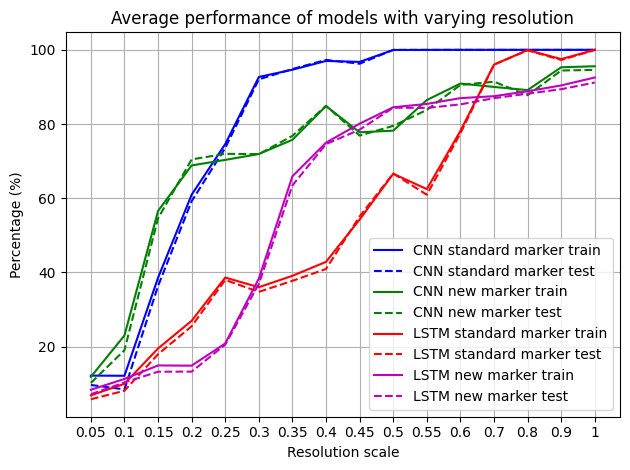

In [16]:
te_cnn=np.load(path+"/data/test_resolutions.npy")*100
tr_cnn=np.load(path+"/data/train_resolutions.npy")*100
te_cnn_n=np.load(path+"/data/test_resolutions_new.npy")*100
tr_cnn_n=np.load(path+"/data/train_resolutions_new.npy")*100

te_lstm=np.load(path+"/data/test_lstm_resolutions.npy")*100
tr_lstm=np.load(path+"/data/train_lstm_resolutions.npy")*100
te_lstm_n=np.load(path+"/data/test_lstm_resolutions_new.npy")*100
tr_lstm_n=np.load(path+"/data/train_lstm_resolutions_new.npy")*100

plt.plot(np.average(tr_cnn,axis=1),c="b",label="CNN standard marker train")
plt.plot(np.average(te_cnn,axis=1),"--",c="b",label="CNN standard marker test")
plt.plot(np.average(tr_cnn_n,axis=1),c="g",label="CNN new marker train")
plt.plot(np.average(te_cnn_n,axis=1),"--",c="g",label="CNN new marker test")
plt.plot(np.average(tr_lstm,axis=1),c="r",label="LSTM standard marker train")
plt.plot(np.average(te_lstm,axis=1),"--",c="r",label="LSTM standard marker test")
plt.plot(np.average(tr_lstm_n,axis=1),c="m",label="LSTM new marker train")
plt.plot(np.average(te_lstm_n,axis=1),"--",c="m",label="LSTM new marker test")
plt.grid(1)
plt.xlabel("Resolution scale")
plt.xticks([i for i in range(len(resolutions))],resolutions)
plt.ylabel("Percentage (%)")
plt.title("Average performance of models with varying resolution")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(path+"/images/resolution_models.pdf")
plt.show()

In [ ]:
torch.save(model.state_dict(), path+"/model/mymodel_lstm_cnn")
print(calc(model,test_loader))
print(calc(model,train_loader))

: 

### Look at resolution

In [5]:
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
test_scores=np.zeros((len(resolutions),5))
train_scores=np.zeros((len(resolutions),5))
for i,res in enumerate(resolutions):
    print("RESOLUTIONS",i,"/",len(resolutions))
    for trial in range(5):
        train_loader,test_loader=genDataANN(0,4,res)
        model,history=runANN(train_loader,0,4)
        test_scores[i][trial]=calc(model,test_loader)
        train_scores[i][trial]=calc(model,train_loader)
        del train_loader
        del model
    np.save(path+"/saves/ANNresolutions_train",train_scores)
    np.save(path+"/saves/ANNresolutions_test",test_scores)


RESOLUTIONS 0 / 16


KeyboardInterrupt: 

In [ ]:
image=next(iter(train_loader))
print(image[0][0][0].shape)

: 

### Look at performance

In [ ]:
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=genData(0,4)
    model,history=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except MemoryError as e:
    try:
        del train_loader
        del test_loader
        del model
    except: 
        pass
    

: 

In [ ]:
#3d 
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=gen3DData(0,4)
    model,history=run3D(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except Exception as e:
    print(e)
    del train_loader
    del test_loader
    del model


: 

In [ ]:
plt.plot(history)
plt.show()
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/ubermodellstmcnn.pdf")

: 

In [ ]:
preds=None
real=None
keys=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'Cotton', 'Plastic', 'Flat', 'Ffoam', 'Gfoam', 'bubble', 'Efoam', 'Jeans', 'Leather']
for i, (inputs, labels) in enumerate(test_loader):
    outputs = model(inputs)
    a=torch.argmax(outputs.detach(),axis=1)
    if type(preds)==type(None):
        preds=a.numpy().copy()
        real=np.argmax(labels.numpy().copy(),axis=1)
    else:
        preds=np.concatenate([preds,a.numpy().copy()])
        real=np.concatenate([real,np.argmax(labels.numpy().copy(),axis=1)])


def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(real)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

print(real.shape,preds.shape)
# Combine all predictions
predictions = [preds]
model_names = ['Neural Network']
num_classes = len(np.unique(real))
un=np.unique(real)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(real, preds, num_classes=len(np.unique(real)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100) if round(value*100,1) == 0.0 else round(value*100,1)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([keys[unique[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([keys[unique[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig(path+"/images/NM_confusionCNN.pdf")
plt.show()

: 

In [ ]:
torch.save(model.state_dict(), "C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel")


: 

In [ ]:
model = SimpleCNN(abs(0-4)*110,120,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

: 

In [ ]:
#perform on unseen pressures

#load in numpy
data=np.load(datapath+"datasets/X_texture_pout.npz")
for array_name in data:
    x_unseen=(data[array_name].astype(np.uint8))
data=np.load(datapath+"datasets/y_texture_pout.npz")
for array_name in data:
    y_unseen=(data[array_name].astype(np.uint8))
print(x_unseen.shape)
#cut temporal size
x_unseen=x_unseen[:,0:4]
X=np.zeros_like(x_unseen)
#apply sobel filter
for i in range(len(x_unseen)): #crop all images individually
    for j in range(len(x_unseen[0])):
        image=x_unseen[i][j]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i][j]=sobel_combined
unique_=["Flat","wool","Efoam","LongCarpet","LacedMatt","cotton","Gfoam","Carpet","felt","Ffoam","bubble","Cork","Jeans"]
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
        
unique_={i:keys[unique_[i]] for i in range(len(unique_))}

#concat
X=X.reshape((4,len(X)//4,1,abs(0-4)*110,120))
X=torch.tensor(X, dtype=torch.float32).to(device)
y=y_unseen.reshape(4,len(y_unseen)//4)
print(X.shape,unique_)
#run through model
predsA=torch.argmax(model(X[0]),axis=1).detach().numpy()
predsB=torch.argmax(model(X[1]),axis=1).detach().numpy()
predsC=torch.argmax(model(X[2]),axis=1).detach().numpy()
predsD=torch.argmax(model(X[3]),axis=1).detach().numpy()
data=np.array([predsA,predsB,predsC,predsD])
for i,batch in enumerate(data):
    for key in np.unique(batch):
        batch[batch==key]=unique_[key]
data=data.reshape((len(x_unseen)))
y=y.reshape((len(x_unseen)))

#show accuracy (maybe confusion matrix of sorts)
correct=0
summed=0.1
a=data==y
summed+=len(x_unseen)
correct+=len(a[a==1])
print("Accuracy:",(correct/summed)*100,"%")

: 

### NUm of classes

In [96]:
#train_loader,test_loader=genData(0,4)
#model,history=run(train_loader,0,4,num_epochs = 100)
train_loader,test_loader=genLSTMData(0,4)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_1575559/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


In [109]:
def filter_loaders_by_classes(train_loader, test_loader, n):
    # Get the class labels from the train_loader (assuming the label is in the second position of each batch)
    train_classes = []  # Use a set to automatically handle uniqueness
    for data, labels in train_loader:
        # Flatten the labels and update the set with unique labels
        l=np.argmax(labels.cpu().numpy().astype(np.uint8),axis=1)
        train_classes.extend(l)  # Flatten to 1D and convert to numpy array
    train_classes=np.array(train_classes).flatten()
    train_classes = train_classes.tolist()  # Convert the set back to a list
    
    # Randomly select 'n' classes
    selected_classes = random.sample(train_classes, n)
    # Function to filter a loader by selected classes
    def filter_loader(loader, selected_classes):
        filtered_data = []
        filtered_labels = []

        for data, labels in loader:
            batch_size = data.size(0)  # Get the batch size
            # Iterate through the batch and check if any label in the sample matches the selected classes
            for i in range(batch_size):
                sample_labels = torch.argmax(labels[i])  # Labels for the i-th sample in the batch
                if sample_labels.cpu().item() in selected_classes:
                    filtered_data.append(data[i])  # Append the corresponding data sample
                    filtered_labels.append(labels[i])  # Append the corresponding labels

        # Convert lists back to tensors
        filtered_data = torch.stack(filtered_data) if filtered_data else torch.Tensor()
        filtered_labels = torch.stack(filtered_labels) if filtered_labels else torch.Tensor()
        # Return a new DataLoader with the filtered data
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(filtered_data, filtered_labels),
            batch_size=loader.batch_size
        )

    # Create the new filtered train and test loaders
    filtered_train_loader = filter_loader(train_loader, selected_classes)
    filtered_test_loader = filter_loader(test_loader, selected_classes)

    return filtered_train_loader, filtered_test_loader

test_acc=np.zeros((15,5))
train_acc=np.zeros((15,5))

for i in range(2,15):
    for j in range(5):
        print("Size",i,"trial",j)
        tl,tl2=filter_loaders_by_classes(train_loader, test_loader, i)
        model,history=runLSTM(tl,0,4,num_epochs = 100)
        test_acc[i][j]=calc(model,tl2)
        train_acc[i][j]=calc(model,tl)

np.save(path+"/data/test_acc_varying_dataset_size_optical_lstm",test_acc)
np.save(path+"/data/train_acc_varying_dataset_size_optical_lstm",train_acc)


Size 2 trial 0
Epoch [1/100], Step [25/25], Loss: 67.1356
Epoch [11/100], Step [25/25], Loss: 48.6685
Epoch [21/100], Step [25/25], Loss: 29.3541
Epoch [31/100], Step [25/25], Loss: 17.6026
Epoch [41/100], Step [25/25], Loss: 8.8964
Epoch [51/100], Step [25/25], Loss: 2.6712
Epoch [61/100], Step [25/25], Loss: 1.1181
Epoch [71/100], Step [25/25], Loss: 0.6429
Epoch [81/100], Step [25/25], Loss: 0.4355
Epoch [91/100], Step [25/25], Loss: 0.3237
Finished Training
Accuracy: 99.95596653456627 %
Accuracy: 99.98972356386805 %
Size 2 trial 1
Epoch [1/100], Step [13/13], Loss: 34.3048
Epoch [11/100], Step [13/13], Loss: 22.6035
Epoch [21/100], Step [13/13], Loss: 8.7108
Epoch [31/100], Step [13/13], Loss: 2.1132
Epoch [41/100], Step [13/13], Loss: 0.8511
Epoch [51/100], Step [13/13], Loss: 0.4799
Epoch [61/100], Step [13/13], Loss: 0.3198
Epoch [71/100], Step [13/13], Loss: 0.2344
Epoch [81/100], Step [13/13], Loss: 0.1824
Epoch [91/100], Step [13/13], Loss: 0.1480
Finished Training
Accuracy: 

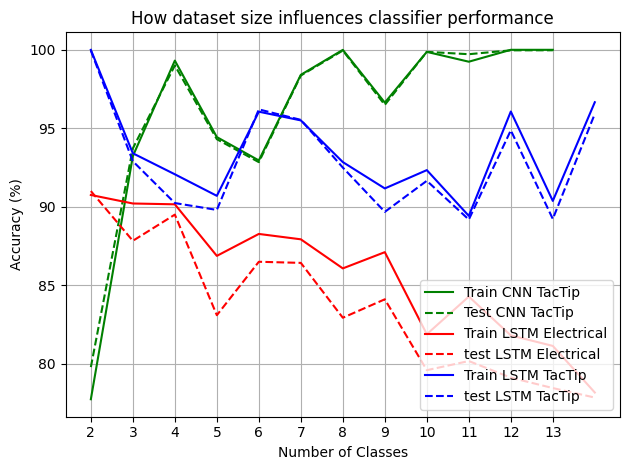

In [18]:
#plot code for above
train_tactip_cnn=np.average(np.load(path+"/data/train_acc_varying_dataset_size_optical_cnn.npy"),axis=1)[2:]*100
test_tactip_cnn=np.average(np.load(path+"/data/test_acc_varying_dataset_size_optical_cnn.npy"),axis=1)[2:]*100
train_press_cnn=np.average(np.load(path+"/data/train_acc_varying_dataset_size_electricalALL_lstm.npy"),axis=1)[2:]
test_press_cnn=np.average(np.load(path+"/data/test_acc_varying_dataset_size_electricalALL_lstm.npy"),axis=1)[2:]
train_tactip_lstm=np.average(np.load(path+"/data/train_acc_varying_dataset_size_optical_lstm.npy"),axis=1)[2:]*100
test_tactip_lstm=np.average(np.load(path+"/data/test_acc_varying_dataset_size_optical_lstm.npy"),axis=1)[2:]*100

plt.plot(train_tactip_cnn,c="g",label="Train CNN TacTip")
plt.plot(test_tactip_cnn,"--",c="g",label="Test CNN TacTip")

plt.plot(train_press_cnn,c="r",label="Train LSTM Electrical")
plt.plot(test_press_cnn,"--",c="r",label="test LSTM Electrical")

plt.plot(train_tactip_lstm,c="b",label="Train LSTM TacTip")
plt.plot(test_tactip_lstm,"--",c="b",label="test LSTM TacTip")

plt.xticks([i for i in range(len(train_tactip_cnn))],[i for i in range(2,14)])
plt.grid(1)
plt.title("How dataset size influences classifier performance")
plt.xlabel("Number of Classes")
plt.ylabel("Accuracy (%)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(path+"/images/datasetsize.pdf")
plt.show()

# Vis

In [ ]:
test=np.load(path+"saves/test_scores.npy")
train=np.load(path+"saves/train_scores.npy")

test=np.max(test,axis=2)*100
"""test=(test-np.min(test))/(np.max(test)-np.min(test))
test*=255"""
test[test==0]=80
plt.imshow(test,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        num=int(test[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')

plt.title("Averaged accuracy of CNN models on testing data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()



train=np.max(train,axis=2)*100
train[train==0]=80
plt.imshow(train,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        num=int(train[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')
plt.title("Averaged accuracy of CNN models on training data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()

: 

## Feature layer

In [ ]:
data=loaded(4,filename="X_data_newMorph.npz")
data.applySobel()
sample_of_data=data.X[0:10]

model = SimpleCNN(abs(4)*data.X.shape[2],data.X.shape[3],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel"))
model.eval()


x_data=data.X[0:4].reshape((len(data.X[0:4]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data))
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)


: 

In [ ]:

#forward pass
x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
print(x[0][0].shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(train_images_tensor[0][0].cpu().detach().numpy(),cmap="gray")
axes[0].axis("off")
axes[0].set_title("Original image",fontsize=11)
for i in range(1,10):
    axes[i].imshow(x[2][i],cmap="gray")
    axes[i].axis("off")
    axes[i].set_title("Feature depth "+str(i+1),fontsize=11)
plt.tight_layout()
plt.savefig(path+"images/featuresALL_uberModel.pdf")
plt.show()

: 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data=loaded(t=4)
data.applySobel()
data.augment()

# Reduce dimensionality with PCA
pca = PCA(n_components=833)
x_data=data.X[0:].reshape((len(data.X[0:]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
labels=data.y[0:]
print(x_data.reshape(len(x_data), -1).shape)
pca_features = pca.fit_transform(x_data.reshape(len(x_data), -1))

# Further reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title('t-SNE Visualization of Optical Tactile Sensor Images')
plt.savefig(path+"/images/clusters.pdf")
plt.show()

: 

# Point prediction

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()

: 

# Just points

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=5)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p


: 

In [ ]:
sample=data.X
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()
del sample
del X_prime
del X_alt

: 

## FNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_layer1_size)
        
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)


        self.fc3 = nn.Linear(hidden_layer2_size, 50)
        
        # Define the output fully connected layer
        self.fc4 = nn.Linear(50, output_size)
    
    def forward(self, x):
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        # Apply the output fully connected layer
        x = self.fc4(x)
        
        return x


: 

In [ ]:
X = np.round(coords.reshape((len(coords),-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
hidden_layer1_size = len(X[0]) //2  # Number of neurons in the first hidden layer
hidden_layer2_size = 800  # Number of neurons in the second hidden layer
output_size = len(un)     # Number of output features

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Print the model architecture
print(model)
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print(X.shape,y.shape,X.dtype,y.dtype)
# Create a TensorDataset and DataLoader
#dataset = TensorDataset(torch.Tensor(train_X).to(device), torch.Tensor(train_y).to(device))
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
coords.reshape((len(coords),-1)).shape

: 

## LSTM

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class SimpleLSTMDrop(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(SimpleLSTMDrop, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

: 

In [ ]:
X = np.round(coords.reshape((len(coords),5,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 100, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

# Point velocities

In [ ]:
def plotchange(average):
    magnitudes=[]
    for t in range(len(average)-1):
        magnitudes.append(euclidean_distance(average[t],average[t+1]))
    ar=np.array(magnitudes).T
    return ar#(ar-np.min(ar))/(np.max(ar)-np.min(ar))

def euclidean_distance(point1, point2):
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    # Calculate the distance
    distance = np.linalg.norm(point1 - point2,axis=1)
    
    return distance

#create dataset
d1=coords[:,:-1,:]
d2=coords[:,1:,:]
distances=np.linalg.norm(d1 - d2,axis=3)



: 

## LSTM

In [ ]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1200

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTMDrop(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

## FNN

In [ ]:
X = distances.reshape((len(distances),-1))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

## CNN

In [ ]:
X = np.round(distances.reshape((len(distances),1,4,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleCNN(len(distances[0]),len(distances[0][0]))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
np.save(path+"/data/distances",distances)
np.save(path+"/data/distancesy",data.y)

: 

# Transferability of normal model 

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodelgel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()
            

: 

In [ ]:

modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()

: 

In [ ]:
print(calc(model,test_loader))
print(calc(model,train_loader))

import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p

: 

In [ ]:
sample=data.X[0:300]
X_prime=np.zeros((len(sample),sample.shape[1],*data.X[0][0].shape),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2)).astype(np.uint16)
divh=X_prime[0][0].shape[0]/270
divw=X_prime[0][0].shape[1]/260
print(divh,divw,X_prime[0][0].shape)
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        temp=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=np.round(predict(reg,temp)[0])
        #X_prime[i][j]*=0 
        for point in zip(coords[i][j][:,0],coords[i][j][:,1]):
            p1=int(point[0]*divh)
            p2=int(point[1]*divw)
            cv2.circle(X_prime[i][j],(p1,p2),1,(255),2)
del sample

: 

In [ ]:
plt.imshow(X_prime[0][0],cmap="gray")
plt.show()
plt.imshow(data.X[0][0],cmap="gray")
plt.show()

: 

In [ ]:
x=(X_prime-np.mean(X_prime))/(np.max(X_prime)-np.min(X_prime))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
print(x.shape)
test=torch.tensor(x, dtype=torch.float32)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")


: 

# saliency maps

In [ ]:
data=loaded(4,filename="X_data_nomarker.npz")
data.applySobel()

: 

In [ ]:
image=data.X[0][0]
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodelnomarker"))
model.eval()
n=10


: 

In [ ]:
#look at frquency 
def generate_saliency_maps(model, inputs, target_class):
    model.eval()
    inputs.requires_grad = True  # Ensure gradients can be computed for input

    # Forward pass to get the predictions
    outputs = model(inputs)  # outputs should be of shape (N, num_classes) if model outputs logits
    score = outputs[:, target_class].sum()  # Sum over the batch for a single target class
    
    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward()
    
    # Get the absolute value of the gradients as saliency map
    saliency = inputs.grad.abs()  # Shape will be (N, t, w, h)

    return saliency

# Plotting Function
def plot_saliency_map(saliency, original_frames, time_index):
    """Plot saliency map for a specific time index in the sequence"""
    # Average over the batch if needed, to show a single example
    saliency_frame = saliency[0, time_index].detach().cpu().numpy()  # Shape (w, h)
    original_frame = original_frames[0, time_index].detach().cpu().numpy()
    
    # Normalize saliency map for visualization
    saliency_frame = (saliency_frame - saliency_frame.min()) / (saliency_frame.max() - saliency_frame.min())
    
    # Plot the original frame with saliency map overlay
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].imshow(original_frame[0:110,:], cmap='gray')
    ax[0].set_title("Original Frame",fontsize=15,**csfont)
    ax[0].axis('off')
    ax[1].imshow(original_frame[0:110,:], cmap='gray')
    ax[1].imshow(saliency_frame[0:110,:], cmap='hot', alpha=0.5)  # Overlay saliency map
    ax[1].set_title(f"Saliency Map - Frame {time_index}",fontsize=15,**csfont)
    ax[1].axis('off')
    plt.tight_layout()
    plt.savefig(path+"/images/saliency_map.pdf")
    plt.show()

# Load a sample from your dataset
shape=data.X[0].shape
n=10
sample_input = torch.tensor(data.X[0:n],dtype=torch.float32).reshape((len(data.X[0:n]),1,4*data.X.shape[2],data.X.shape[3]))  # Shape (1, t, w, h) - single sample for visualization

print(sample_input.shape)
# Generate saliency maps for the sample
target_class = 0  # Replace with the class index of interest
saliency_maps = generate_saliency_maps(model, sample_input, target_class)

# Plot saliency for each frame in the temporal sequence
for time_index in range(sample_input.shape[1]):  # Iterate over t frames
    plot_saliency_map(saliency_maps, sample_input, time_index)

: 

## Taking out segments



In [ ]:
data=loaded(4,filename="X_data_15.npz")
data.applySobel()

: 

In [ ]:

sample=data.X[0:300].reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
images=[sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy()]
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
label=["50:75","20:45","70:95","60:70","Segment removed","Two removed","Three removed","Only first and last"]
label=["A","B","C","D","E","F","G","H"]
sample[:,0:330,0:120]=0
#sample=sample.reshape((300,4,len(data.X[0][0])*len(data.X[0][0][0]))).copy()

fig, axes = plt.subplots(1, len(images), figsize=(15,8))
axes = axes.flatten()
for i in range(len(images)):
    axes[i].set_title(label[i],fontsize=30,**csfont)
    axes[i].imshow(images[i])
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(path+"/images/samplesCrops_.pdf")
plt.show()


: 

In [ ]:
sample=data.X[0:300].reshape((300,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
"""
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
"""
sample[:,110:330,0:120]=0
#sample=sample.reshape((300,4,len(data.X[0][0])*len(data.X[0][0][0]))).copy() # lstm
sample=sample.reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()

image=sample[0][0]
print(image.shape)
#model=SimpleCNN(data.X.shape[2]*4,data.X.shape[3],15).to(device)#.half()
"""model=SimpleLSTM(image.shape[1],1000,15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()"""
model = SimpleCNN(image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
#x=x.reshape((len(x),4,x.shape[2]//4*x.shape[3]))

print(x.shape)
test=torch.tensor(x, dtype=torch.float32).to(device)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")
plt.imshow(image.reshape((4*len(data.X[0][0]),len(data.X[0][0][0]))))
plt.show()

: 

In [ ]:
matrixA=np.array([[56.3,98,99.3],[52,100,53.3],[72.3,100,70],[89.33,100,100],[98.6,100,95.6],[91.3,100,64.6],[83.3,97,47.3],[97,100,79.6]]) #cnn
matrixB=np.array([[43.4,63,100],[19.3,92.6,12.3],[23.3,86,83.6],[88.6,90.3,100],[86,68.3,86.3],[72.6,45,56.9],[49,34,32.6],[68.6,61.6,60]])
fig, ax = plt.subplots(figsize=(10, 6))

# Plot matrixA in the top half with 'YlGn' colormap
ax.imshow(matrixA.T, cmap='YlGn', aspect='auto', extent=[0, 8, 6, 3])

# Plot matrixB in the bottom half with 'gray' colormap
ax.imshow(matrixB.T, cmap='YlOrRd', aspect='auto', extent=[0, 8, 3, 0])

# Set ticks
ax.set_xticks(np.arange(8) + 0.5)
ax.set_xticklabels(["A","B","C","D","E","F","G","H"],fontsize=20,**csfont)
ax.set_yticks(np.arange(6)+1)
ax.set_yticklabels(["  NM", "  S", "  0M", "  NM", "  S", "  0M"], rotation=90, ha="left", rotation_mode="anchor",fontsize=20,**csfont)


# Add text annotations
for i in range(matrixA.shape[0]):
    for j in range(matrixA.shape[1]):
        ax.text(i+0.5, j+0.5+3, f"{matrixA[i, j]:.1f}%", ha='center', va='center', color='white' if matrixA[i, j] > 70 else 'black',fontsize=18,**csfont)

for i in range(matrixB.shape[0]):
    for j in range(matrixB.shape[1]):
        ax.text(i+0.5, j+0.5, f"{matrixB[i, j]:.1f}%", ha='center', va='center', color='white' if matrixB[i, j] > 90 else 'black',fontsize=18,**csfont)


plt.title("Model results",fontsize=20,**csfont)
plt.tight_layout()
plt.savefig(path+"/images/LSTM_different_markers.pdf")
plt.show()

: 

# Different pressures

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodel_withLowPressure") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
print(calc(model,test_loader))
print(calc(model,train_loader))

: 

In [ ]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()
#print(calc(model,test_loader))
#print(calc(model,train_loader))

: 

In [ ]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
d.applySobel()
sample=d.X
label=d.y


: 

In [ ]:
sample=d.X
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),x.shape[1],x.shape[2]*x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds[preds==11]
print(len(a)/len(preds) *100,"%")
del test
del x

: 

In [ ]:
p20=d.X[np.where(d.y==3)]
p30=d.X[np.where(d.y==0)]
p40=d.X[np.where(d.y==2)]
p50=d.X[np.where(d.y==1)]
data=[p20,p30,p40,p50]
accs=[]
for i in range(4):
    sample=data[i]
    label=11
    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))  #n,1,t*h,w for cnn, n,t,h*w for lstm, n,1,t,h,w for cnn-lstm
    test=torch.tensor(x, dtype=torch.float32).to(device)
    preds=model(test)
    preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
    a=len(preds[preds==label])
    print(a/len(preds) *100,"%")

: 

# models on other data sets

In [ ]:
data=loaded(4,filename="X_data_nomarker.npz")
image=data.X[0][0].copy()
del data
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#print(calc(model,test_loader))
#print(calc(model,train_loader))

: 

In [ ]:
#model=SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)
model=CNN_LSTM(image.shape[1],image.shape[0],1000,1,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_lstmCNN"))
model.eval()

: 

In [ ]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_data_nomarker.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
sample=d.X[0:800]
label=d.y[0:800]
del d
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1],x.shape[2],x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds-label
print(len(a[a==0])/len(preds) *100,"%")
del test
del x


: 

# Transferring large models to small

In [ ]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

: 

In [ ]:
d=loaded(t=4,filename="X_data_15.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
d.resize(0.1)

sample=d.X
sampley=d.y
image=sample[0][0]
print(image.shape)
#copy over correct convolutions
modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],15).to(device)
modelB.conv1=model.conv1
modelB.conv2=model.conv2
#freeze conv layers
modelB.conv1.requires_grad=False
modelB.conv2.requires_grad=False


: 

In [ ]:


label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(sampley)
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)


: 

In [ ]:
#train
train_history=[]
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(modelB.parameters(), lr=0.005)

# Train the Model
num_epochs=50
clip_value = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = modelB(inputs)
        #print(inputs.shape,outputs.shape,labels.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    train_history.append(loss.cpu().detach().numpy())
    if epoch%10==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
print('Finished Training')

: 

In [ ]:
print(calc(modelB,test_loader))
print(calc(modelB,train_loader))

: 

In [ ]:
#GEL
# 5%
# train % 58.95 test 57.99 % 

#10%
# train % 91.70 test 92.81 % 

#15%
# train % 93.37 test 94.81

#20%
# train % 96.99 test 98.15

#25%
# train % 99.9 test 99.98 % 

#NEWMORPH
# 5%
# train % 74.32 test 75.37 % 

#10%
# train % 89.17 test 89.02 % 

#15%
# train % 82.92 test 84.98 %

#20%
# train % 96.87 test 95.75 %

#25%
# train % 90.1 test 88.25 % 

#SILICONE
# 5%
# train % - test - % 

#10%
# train % - test - % 

#15%
# train % 79 test 74 %

#20%
# train % 88 test 90 %

#25%
# train % - test - % 

: 

## automate

In [ ]:
#automate the shit out of it
def long(file,type1,num):
    resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
    acc_test=np.zeros((len(resolution),5))
    acc_train=np.zeros((len(resolution),5))
    num_epochs=80
    history=np.zeros((len(resolution),5,num_epochs))

    for i in range(len(resolution)):
        d=loaded(t=4,filename=file) #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
        d.applySobel()
        image=d.X[0][0]
        model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
        model.load_state_dict(torch.load(path+"/model/mymodelgel"))
        model.eval()
        d.resize(resolution[i])
        
        sample=d.X
        sampley=d.y
        image=sample[0][0]
        print(image.shape)
        
        #copy over correct convolutions
        modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],num).to(device)
        modelB.conv1=model.conv1
        modelB.conv2=model.conv2
        #freeze conv layers
        modelB.conv1.requires_grad=False
        modelB.conv2.requires_grad=False


        label_encoder = LabelEncoder()
        train_labels_encoded = label_encoder.fit_transform(sampley)
        one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
        x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
        x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

        train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

        # Create a TensorDataset
        dataset = TensorDataset(train_images_tensor, train_labels_tensor)
        # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create DataLoader for training and testing sets
        train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
        max_=0
        for j in range(5):
            clear_output(wait=True)
            print("Resolution",resolution[i],"Trial",j)
            criterion = nn.CrossEntropyLoss().to(device)
            optimizer = optim.SGD(modelB.parameters(), lr=0.005)

            # Train the Model
            
            clip_value = 5
            for epoch in range(num_epochs):
                running_loss = 0.0
                for k, (inputs, labels) in enumerate(train_loader):
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = modelB(inputs)
                    #print(inputs.shape,outputs.shape,labels.shape)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
                    optimizer.step()

                    # Print statistics
                    running_loss += loss.item()
                history[i][j][epoch]=running_loss/(k+1) #save average loss per epoch
            test=calc(modelB,test_loader)
            train=calc(modelB,train_loader)
            acc_train[i][j]=train
            acc_test[i][j]=test
            if test>max_:
                max_=test
                torch.save(modelB.state_dict(), path+"/model/standard_c_gel/cnn_res"+str(resolution[i])+"_"+str(type1))
        del train_loader
        del test_loader
    
    np.save(path+"/data/train_uber_"+type1+"_long_standard_c",acc_train)
    np.save(path+"/data/test_uber_"+type1+"_long_standard_c",acc_test)
    np.save(path+"/data/histroy_"+type1+"_long_standard_c",history)

#X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
long("X_data_gel_15.npz","gel",15)
#long("X_data_15.npz","sil",15)
#long("X_data_newMorph.npz","nm",13)


: 

## vis

In [ ]:
sil_train=np.load(path+"/data/train_uber_sil_long_standard_c.npy")
sil_test=np.load(path+"/data/test_uber_sil_long_standard_c.npy")
gel_train=np.load(path+"/data/train_uber_gel_long_standard_c.npy")
gel_test=np.load(path+"/data/test_uber_gel_long_standard_c.npy")
#nm_train=np.load(path+"/data/train_uber_nm_long.npy")
#nm_test=np.load(path+"/data/test_uber_nm_long.npy")

average_sil_test=np.average(sil_test,axis=1)*100
max_sil_test=np.max(sil_test,axis=1)*100
average_sil_train=np.average(sil_train,axis=1)*100
average_gel_test=np.average(gel_test,axis=1)*100
max_gel_test=np.max(gel_test,axis=1)*100
average_gel_train=np.average(gel_train,axis=1)*100
#average_nm_test=np.average(nm_test,axis=1)*100
#max_nm_test=np.max(nm_test,axis=1)*100
#average_nm_train=np.average(nm_train,axis=1)*100

plt.plot(average_sil_test,c="b",label="Silicone test")
plt.plot(max_sil_test,"--",c="b",label="Silicone max")
plt.plot(average_gel_test,c="g",label="Gel test")
plt.plot(max_gel_test,"--",c="g",label="Gel max")
#plt.plot(average_nm_test,c="r",label="NM test")
#plt.plot(max_nm_test,"--",c="r",label="NM max")

#plt.plot(average_sil_train,c="b",label="Silicone train")
resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
plt.xticks([i for i in range(len(resolution))],resolution)
plt.ylabel("Aacuracy %")
plt.xlabel("Resolution multiplier")
plt.title("Resolution vs accuracy on pretrained conv layer",fontsize=14)
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig(path+"/images/resolution_just_own_transfer.pdf")
plt.show()

: 

In [ ]:
import matplotlib.cm as cm

sil_history=np.load(path+"/data/histroy_sil_long_untrained.npy")
gel_history=np.load(path+"/data/histroy_gel_long_untrained.npy")
nm_history=np.load(path+"/data/histroy_nm_long_untrained.npy")
print(sil_history.shape)

sil_history_av=np.average(sil_history,axis=1)
#gel_history_av=np.average(gel_history,axis=1)
#nm_history_av=np.average(nm_history,axis=1)
print(sil_history_av.shape)
# Create a colormap that gets darker
colors = cm.viridis(np.linspace(0, 1, len(resolution)))

for i in range(len(sil_history_av)):
    plt.plot(sil_history_av[i],color=colors[i],label="Resolution "+str(resolution[i]))
#plt.plot(gel_history_av,label="Average loss gel")
#plt.plot(nm_history_av,label="Average loss new morphology")
plt.title("Loss over training")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig(path+"/images/resolution_loss_untrained.pdf")
plt.show()

: 

## Feature layers

In [ ]:
images_X=[]
images_f=[]
images_o=[]
for i in range(len(resolution)-1):
    filename="cnn_res"+str(resolution[i])+"_gel"

    data=loaded(4,filename="X_data_15.npz")
    data.applySobel()
    data.resize(resolution[i])
    image=data.X[0][0]

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/res/"+filename))
    model.eval()

    sample=data.X[0:13]
    sampley=data.y[0:13]

    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

    train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_X.append(train_images_tensor[0][0].cpu().detach().numpy())
    images_f.append(x.copy())

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/learnedres/"+filename))
    model.eval()

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_o.append(x.copy())


: 

In [ ]:

fig, axes = plt.subplots(3, len(resolution)-1, figsize=(10, 8))
#axes = axes.flatten()

for i in range(len(images_X)):
    axes[0][i].imshow(images_X[i],cmap="gray")
    axes[0][i].axis("off")
    axes[0][i].set_ylabel("Original res "+str(resolution[i]),fontsize=11)
    #print(images_f[i][0].shape)
    axes[1][i].imshow(images_f[i][0][0],cmap="gray")
    axes[1][i].axis("off")
    #axes[1][i].set_title("Feature res"+str(resolution[i]),fontsize=11)
    axes[2][i].imshow(images_o[i][1][0],cmap="gray")
    axes[2][i].axis("off")

plt.tight_layout()
plt.savefig(path+"images/features_norm_transfer.pdf")
plt.show()

: 

# playing with points

In [7]:
data=loaded(t=10)
data.applySobel()

data2=loaded(filename="X_data_newMorph.npz",t=10)
data2.applySobel()

data3=loaded(filename="X_data_nomarker.npz",t=10)
data3.applySobel()

#data.augment()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [8]:
def compute_dense_optical_flows(dataset):
    n, t, h, w = dataset.shape
    optical_flows = np.zeros((n, t-1, h, w), dtype=np.uint8)  # Change to uint8 for 0-255 range
    
    # Optical flow parameters for higher sensitivity
    pyr_scale = 0.1     # Lowered for more sensitivity to small movements
    levels = 20         # Increased number of pyramid levels
    winsize = 5         # Reduced window size for finer detail
    iterations = 6      # More iterations per level
    poly_n = 5          # Polynomial window size (typically fixed)
    poly_sigma = 1.0    # Lowered for more detailed flow calculations
    
    for i in range(n):  # Loop over each sample
        for j in range(t - 1):  # Loop over each pair of frames
            # Convert frames to grayscale if needed
            frame1 = dataset[i, j].astype(np.uint8)
            frame2 = dataset[i, j + 1].astype(np.uint8)
            
            # Calculate dense optical flow with more sensitive parameters
            flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 
                                                pyr_scale, levels, winsize, 
                                                iterations, poly_n, poly_sigma, 0)
            
            # Calculate the magnitude and angle of the flow
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            
            # Normalize the magnitude to the range 0-255 and convert to uint8
            mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            optical_flows[i, j] = mag  # Store the normalized magnitude

    return optical_flows


def compute_dense_optical_flows(dataset):
    n, t, h, w = dataset.shape
    optical_flows = np.zeros((n, t-1, h, w), dtype=np.uint8)  # Change to uint8 for 0-255 range
    
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    for i in range(n):  # Loop over each sample
        for j in range(t - 1):  # Loop over each pair of frames
            # Convert frames to grayscale if needed
            frame1 = dataset[i, j].astype(np.uint8)
            frame2 = dataset[i, j + 1].astype(np.uint8)
            
            # Detect good features to track in the first frame
            p0 = cv2.goodFeaturesToTrack(frame1, mask=None, maxCorners=500, qualityLevel=0.01, minDistance=5)
            
            # Calculate optical flow using Lucas-Kanade
            p1, st, err = cv2.calcOpticalFlowPyrLK(frame1, frame2, p0, None, **lk_params)
            
            # Filter only good points where flow is successfully calculated
            if p1 is not None:
                good_new = p1[st == 1]
                good_old = p0[st == 1]
                
                # Create a mask to draw the optical flow vectors
                mask = np.zeros_like(frame1, dtype=np.uint8)
                
                # Draw the optical flow vectors
                for (new, old) in zip(good_new, good_old):
                    a, b = new.ravel()
                    c, d = old.ravel()
                    cv2.line(mask, (int(c), int(d)), (int(a), int(b)), 255, 1)
                    
                # Store the mask as the flow field representation for this pair of frames
                optical_flows[i, j] = mask

    return optical_flows
    
flow_data=compute_dense_optical_flows(data.X)
flow_data2=compute_dense_optical_flows(data2.X)
flow_data3=compute_dense_optical_flows(data3.X)


In [9]:
def augment(dataset, y, segment_size=0.2):
    n, t, h, w = dataset.shape
    
    # Create an empty array for the augmented data
    augmented_data = dataset.copy()
    
    for i in range(n):
        for j in range(t):
            # Randomly determine the segment's position and size
            seg_h = int(h * segment_size)
            seg_w = int(w * segment_size)
            start_h = np.random.randint(0, h - seg_h)
            start_w = np.random.randint(0, w - seg_w)
            
            # Remove (mask) the segment in the image
            augmented_data[i, j, start_h:start_h + seg_h, start_w:start_w + seg_w] = 0
    
    # Concatenate the original and augmented data
    combined_data = np.concatenate((dataset, augmented_data), axis=0)
    
    # Duplicate the labels for the augmented dataset
    combined_y = np.concatenate((y, y), axis=0)
    
    # Shuffle the combined dataset and labels together
    indices = np.arange(2 * n)
    np.random.shuffle(indices)
    combined_data = combined_data[indices]
    combined_y = combined_y[indices]
    
    return combined_data, combined_y

flow_data_a,flow_y=augment(flow_data,data.y)
#flow_data_a,flow_y=augment(np.concatenate([flow_data,flow_data2,flow_data3]),np.concatenate([data.y,data2.y,data3.y]))
flow_data_a,flow_y=augment(flow_data_a,flow_y)
flow_data_a,flow_y=augment(flow_data_a,flow_y)
#flow_data_a,flow_y=augment(flow_data2,data2.y)
#flow_data_a=flow_data
#flow_y=data.y

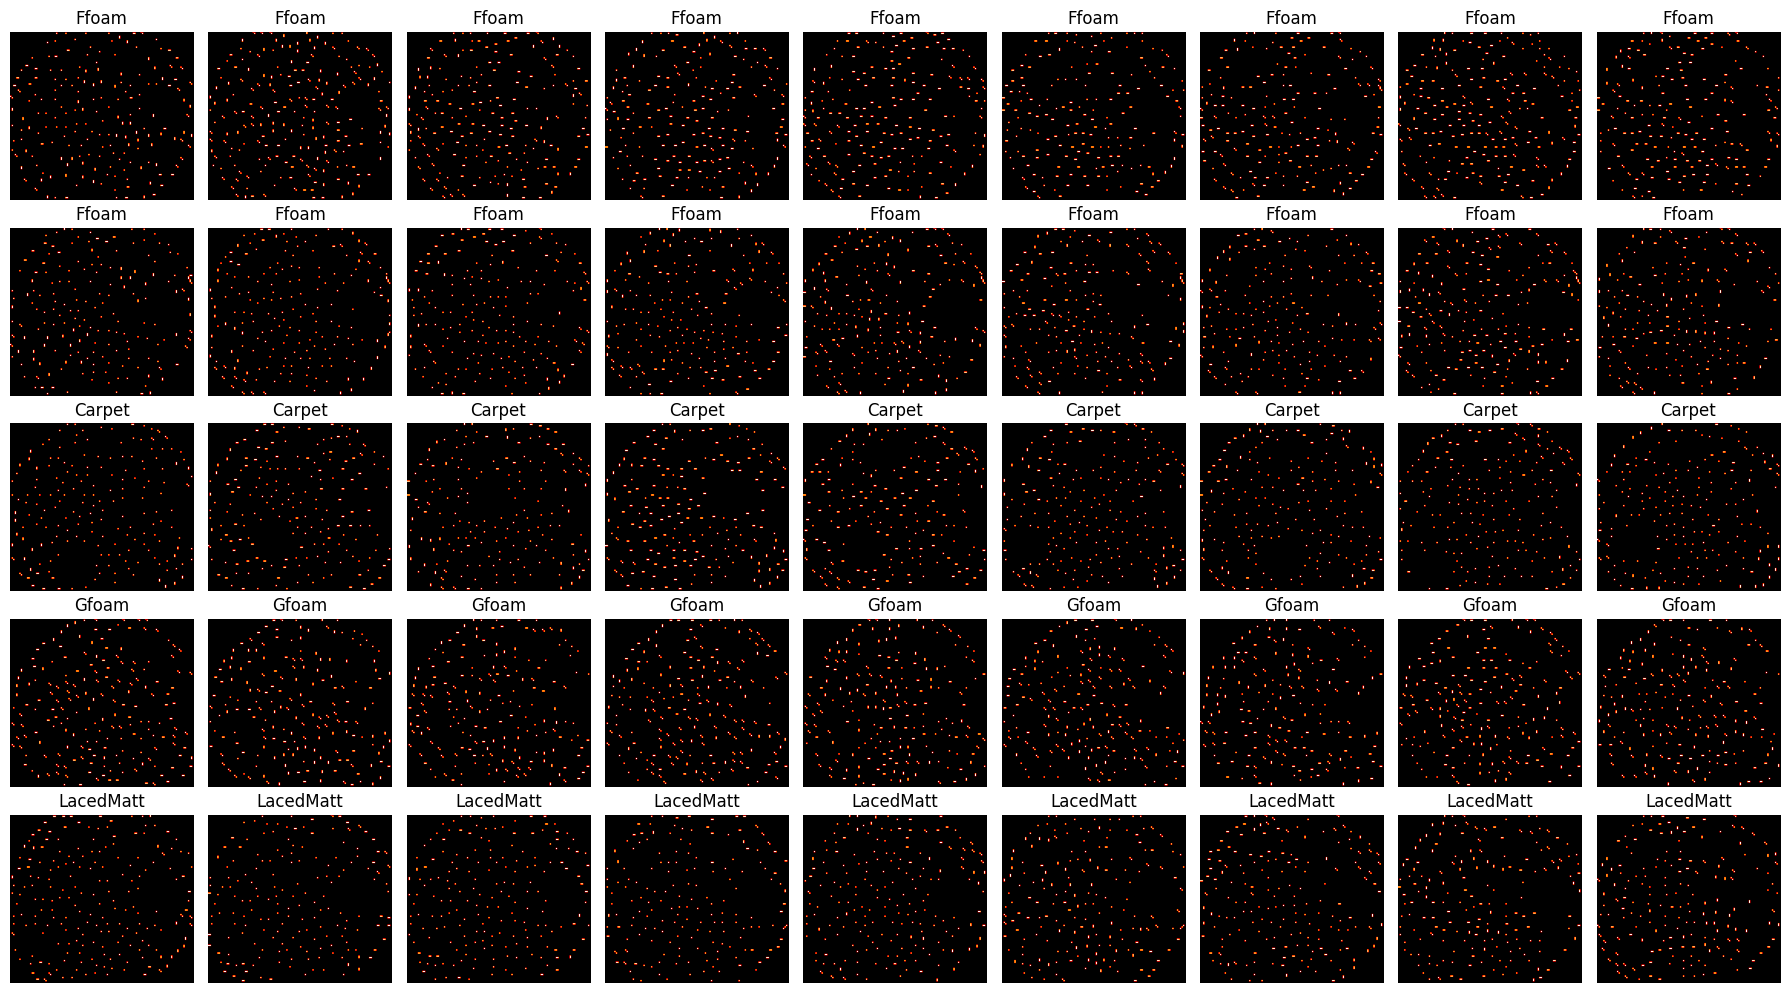

In [9]:
def plot_images_grid(images_grid,data):
    """
    Plots a grid of images, where each sublist in images_grid represents a row of images.
    
    Parameters:
    images_grid (list of lists): List of lists where each sublist contains images for a row.
    """
    num_rows = len(images_grid)
    num_cols = max(len(row) for row in images_grid)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    
    # Flatten axes if there's only one row or column for consistency
    if num_rows == 1:
        axes = [axes]
    if num_cols == 1:
        axes = [[ax] for ax in axes]
    c=0
    # Plot each image in the correct position
    for row_idx, row_images in enumerate(images_grid):
        for col_idx, img in enumerate(row_images):
            ax = axes[row_idx][col_idx]
            ax.set_title(data.keys[data.y[c]])
            ax.imshow(img, cmap='gist_heat' if img.ndim == 2 else None)
            ax.axis('off')  # Hide the axes for a cleaner look
        c+=1
    # Hide any unused subplots if the rows have different lengths
    for row_idx in range(num_rows):
        for col_idx in range(len(images_grid[row_idx]), num_cols):
            axes[row_idx][col_idx].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_grid(flow_data_a[0:5],data)

## train network on this

In [16]:
n=-1
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(flow_y[0:n])
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x_data=flow_data_a[0:n].reshape((len(flow_data_a[0:n]),1,abs(flow_data_a.shape[1])*flow_data_a.shape[2],flow_data_a.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
del x_data
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelcnn_optic_flow") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

/tmp/ipykernel_1598864/836657166.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [480/480], Loss: 1117.2915
Epoch [11/100], Step [480/480], Loss: 0.4085
Epoch [21/100], Step [480/480], Loss: 0.1551
Epoch [31/100], Step [480/480], Loss: 0.0913
Epoch [41/100], Step [480/480], Loss: 0.0633
Epoch [51/100], Step [480/480], Loss: 0.0479
Epoch [61/100], Step [480/480], Loss: 0.0383
Epoch [71/100], Step [480/480], Loss: 0.0317
Epoch [81/100], Step [480/480], Loss: 0.0270
Epoch [91/100], Step [480/480], Loss: 0.0234
Finished Training
Accuracy: 99.99791671006854 %
0.9999791671006854
Accuracy: 99.99947914225147 %
0.9999947914225147


### lstm

In [37]:
n=-1
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(flow_y[0:n])
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x_data=flow_data_a[0:n].reshape((len(flow_data_a[0:n]),abs(flow_data_a.shape[1]),flow_data_a.shape[2]*flow_data_a.shape[3]))
#x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
x/=255
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
del x_data
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
model,history=runLSTM(train_loader,0,10,num_epochs = 200)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodellstm_optic_flow") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

/tmp/ipykernel_1594693/4159573806.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/200], Step [120/120], Loss: 324.6456
Epoch [11/200], Step [120/120], Loss: 318.7175
Epoch [21/200], Step [120/120], Loss: 292.4398
Epoch [31/200], Step [120/120], Loss: 218.4090
Epoch [41/200], Step [120/120], Loss: 157.8653
Epoch [51/200], Step [120/120], Loss: 91.5385
Epoch [61/200], Step [120/120], Loss: 40.7039
Epoch [71/200], Step [120/120], Loss: 14.5386
Epoch [81/200], Step [120/120], Loss: 6.3397
Epoch [91/200], Step [120/120], Loss: 3.7677
Epoch [101/200], Step [120/120], Loss: 2.5890
Epoch [111/200], Step [120/120], Loss: 1.9344
Epoch [121/200], Step [120/120], Loss: 1.5251
Epoch [131/200], Step [120/120], Loss: 1.2475
Epoch [141/200], Step [120/120], Loss: 1.0491
Epoch [151/200], Step [120/120], Loss: 0.9001
Epoch [161/200], Step [120/120], Loss: 0.7854
Epoch [171/200], Step [120/120], Loss: 0.6945
Epoch [181/200], Step [120/120], Loss: 0.6211
Epoch [191/200], Step [120/120], Loss: 0.5606
Finished Training
Accuracy: 98.82509790850763 %
0.9882509790850763
Accuracy: 9

In [10]:
n=-1
x_data=flow_data[0:n].reshape((len(flow_data[0:n]),abs(flow_data.shape[1]),flow_data.shape[2]*flow_data.shape[3]))
image=x_data[0][0]
model = SimpleLSTM(image.shape[0],350,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodellstm_optic_flow"))
model.eval()

/tmp/ipykernel_1598864/1168738564.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"/model/mymodellstm_optic_flow"))


RuntimeError: Error(s) in loading state_dict for SimpleLSTM:
	Unexpected key(s) in state_dict: "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1", "lstm.weight_ih_l2", "lstm.weight_hh_l2", "lstm.bias_ih_l2", "lstm.bias_hh_l2". 

In [9]:
n=-1
x_data=flow_data[0:n].reshape((len(flow_data[0:n]),1,abs(flow_data.shape[1])*flow_data.shape[2],flow_data.shape[3]))
image=x_data[0][0]
model = SimpleCNN(image.shape[0],image.shape[1],15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodelcnn_optic_flow"))
model.eval()

/tmp/ipykernel_1599463/2210332082.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"/model/mymodelcnn_optic_flow"))


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=74100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [26]:
sample=200
torch.cuda.empty_cache()
x=torch.tensor(flow_data2.reshape((flow_data2.shape[0],flow_data2.shape[1],flow_data2.shape[2]*flow_data2.shape[3])), dtype=torch.float32).to(device) #lstm
#x=torch.tensor(flow_data2.reshape((flow_data2.shape[0],1,flow_data2.shape[1]*flow_data2.shape[2],flow_data2.shape[3])), dtype=torch.float32).to(device) #cnn
x/=255
#x=(x-torch.mean(x))/(torch.max(x)-torch.min(x)) #preprocessing
preds=model(x[0:sample])
vals=torch.argmax(preds,axis=1).cpu().detach().numpy()
error=np.abs(vals-data2.y[0:sample])

print("Accuracy ",len(np.where(error==0)[0]),"/400",":",len(np.where(error==0)[0])/400 *100,"%")

Accuracy  24 /400 : 6.0 %


In [27]:
torch.cuda.empty_cache()
sample=200
x=torch.tensor(flow_data3.reshape((flow_data3.shape[0],flow_data3.shape[1],flow_data3.shape[2]*flow_data3.shape[3])), dtype=torch.float32).to(device) #lstm
#x=torch.tensor(flow_data3.reshape((flow_data3.shape[0],1,flow_data3.shape[1]*flow_data3.shape[2],flow_data3.shape[3])), dtype=torch.float32).to(device) #cnn
x/=255
#x=(x-torch.mean(x))/(torch.max(x)-torch.min(x)) #preprocessing
preds=model(x[0:sample])
vals=torch.argmax(preds,axis=1).cpu().detach().numpy()
error=np.abs(vals-data3.y[0:sample])

print("Accuracy ",len(np.where(error==0)[0]),"/400",":",len(np.where(error==0)[0])/400 *100,"%")

Accuracy  19 /400 : 4.75 %


## transformers

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Embedding layer to convert inputs to model dimension
        self.embedding = nn.Linear(input_dim, model_dim)
        
        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer to map to number of classes
        self.fc_out = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        # Apply embedding
        x = self.embedding(x)
        
        # Transformer encoder expects input as (sequence_length, batch_size, model_dim)
        x = x.permute(1, 0, 2)
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)
        
        # Get the mean of the output sequence (global average pooling)
        x = x.mean(dim=0)
        
        # Output layer
        output = self.fc_out(x)
        return output

In [22]:

def train_Tmodel(model, train_loader, test_loader, num_epochs, learning_rate=0.001):
    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Train the model on the training data
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.argmax(outputs,axis=1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels,axis=1)).sum().item()

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Evaluate the model on the test data
        evaluate_Tmodel(model, test_loader)

def evaluate_Tmodel(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs,axis=1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels,axis=1)).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")




In [ ]:
n=-1
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(flow_y[0:n])
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x_data=flow_data_a[0:n].reshape((len(flow_data_a[0:n]),abs(flow_data_a.shape[1]),flow_data_a.shape[2]*flow_data_a.shape[3])).astype(np.float64)
#x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
x_data/=255
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

In [24]:
#tomorrow to do
#work out paramaters for model
model=TransformerModel(x_data.shape[2],20,20,3,15).to(device)
train_Tmodel(model, train_loader, test_loader,10)

Epoch 1/10, Loss: 0.3043, Train Accuracy: 96.57%
Test Accuracy: 100.00%
Epoch 2/10, Loss: 0.0130, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 3/10, Loss: 0.0045, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 4/10, Loss: 0.0022, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 5/10, Loss: 0.0013, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 6/10, Loss: 0.0008, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 7/10, Loss: 0.0005, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 8/10, Loss: 0.0004, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 9/10, Loss: 0.0003, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 10/10, Loss: 0.0002, Train Accuracy: 100.00%
Test Accuracy: 100.00%


In [29]:
data.X.shape

(3000, 10, 110, 120)

# General experiments *salute* 

In [78]:
import numpy as np
import random

def augment_with_missing_data(data, mask_fraction=0.3, random_seed=None):
    """
    Augments a dataset by randomly removing large portions of the data.

    Parameters:
    - data (numpy array): Input data of shape (n, t, h, w)
    - mask_fraction (float): Fraction of each image to be removed (0-1)
    - random_seed (int): Optional seed for reproducibility

    Returns:
    - augmented_data (numpy array): Augmented dataset
    """
    if random_seed:
        random.seed(random_seed)
        np.random.seed(random_seed)
    
    n, t, h, w = data.shape
    augmented_data = data.copy()
    
    for i in range(n):
        for j in range(t):
            # Determine mask size
            mask_height = int(h * mask_fraction)
            mask_width = int(w * mask_fraction)
            
            # Choose a random position for the mask
            top_left_y = random.randint(0, h - mask_height)
            top_left_x = random.randint(0, w - mask_width)
            
            # Apply the mask
            augmented_data[i, j, top_left_y:top_left_y + mask_height, top_left_x:top_left_x + mask_width] = 0
    
    return augmented_data

# Example usage:
data=loaded(t=5)
data.applySobel()
data.augment()
augmented_data = augment_with_missing_data(data.X, mask_fraction=0.3, random_seed=42)
data_=augmented_data.reshape((len(augmented_data),-1))

KeyboardInterrupt: 

In [71]:

n_components = 30  # Number of principal components to retain
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(data_)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 5 
Image: (110, 120)
Memory needed: 0.55 GB


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
X_train, X_test, y_train, y_test = train_test_split(pca_data, data.y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of Random Forest Classifier:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy of Random Forest Classifier: 0.9994444444444445

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00       126
           2       1.00      1.00      1.00       108
           3       1.00      1.00      1.00       126
           4       1.00      1.00      1.00       112
           5       1.00      1.00      1.00       106
           6       1.00      1.00      1.00       116
           7       1.00      1.00      1.00       118
           8       1.00      1.00      1.00       133
           9       1.00      0.99      1.00       109
          10       1.00      1.00      1.00       126
          11       1.00      1.00      1.00       122
          12       0.99      1.00      1.00       113
          13       1.00      1.00      1.00       124
          14       1.00      1.00      1.00       135

    accuracy                           1.00      1800

In [75]:
data=loaded(filename="X_data_newMorph.npz",t=5)
data.applySobel()
data.augment()

data_alt=data.X.reshape((len(data.X),-1))
pca_data = pca.fit_transform(data_alt)
y_pred = rfc.predict(pca_data)
accuracy = accuracy_score(data.y, y_pred)
print("Accuracy of Random Forest Classifier:", accuracy)
print("\nClassification Report:")

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 5 
Image: (110, 120)
Memory needed: 0.55 GB
